# Simulated active learning loop based on ConvNeXt


<b> What are we doing here? <b>

1. Load the pretrained ConvNeXt backbone (red) from Hugging Face
2. Load the fine-tuned classification model (blue) and extract its weights, especially the ConvNeXt backbone
3. Create a new regression model (orange) by modifying ConvNextWithCustomFC to have a regression head instead of a classification head
4. Transfer the pretrained weights from the blue model to the orange model while ensuring the ConvNeXt backbone remains unchanged and that the new regression head is properly initialized
5. Verify that the weights have been correctly loaded, particularly ensuring that the ConvNeXt backbone remains the same.

In [134]:
!pip install numpy==1.26.4 torch==2.1.0 torchvision==0.16.0 \
    transformers==4.48.1 pillow==9.2.0 anndata==0.10.3 scanpy==1.9.6 \
    matplotlib gputil leidenalg umap-learn h5py requests \
    "scikit-learn>=0.24" statsmodels==0.14.4 session-info patsy \
    safetensors==0.5.2 tokenizers==0.21.0 huggingface-hub==0.27.1 \
    llvmlite==0.44.0 numba==0.61.0 stdlib-list==0.11.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [135]:
# Standard library imports
import os
import re
import glob
import random
#import pandas as pd
import pickle
from collections import Counter

# Third-party imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, utils
import numpy as np
import h5py
import umap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import requests

# Transformers library imports
from transformers import AutoImageProcessor, ConvNextModel, ConvNextConfig
from sklearn.neighbors import NearestNeighbors

# Project-specific imports
from sparcscore.ml.datasets import HDF5SingleCellDataset
from sparcscore.ml.transforms import RandomRotation, GaussianNoise, ChannelReducer, ChannelSelector
from sparcscore.ml.utils import combine_datasets_balanced
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

In [2]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration for ConvNext
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Load the pretrained ConvNext model (red!)
original_model = ConvNextModel.from_pretrained("facebook/convnext-xlarge-224-22k")
original_model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ConvNextModel(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            

In [2]:
# model with a classification head (blue!)
class ConvNextWithCustomFC(ConvNextModel):
    def __init__(self, config, num_classes=2):
        super().__init__(config)
        # FC layer for classification
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extracct the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            # Perform mean pooling across the spatial dimensions
            embeddings = outputs.last_hidden_state.mean(dim=1)
        
        # Pass embedings through classification head
        logits = self.fc(embeddings)
        return logits

In [28]:
# Load the fine-tuned classification model (Blue)
classification_model = ConvNextWithCustomFC.from_pretrained(
    "facebook/convnext-xlarge-224-22k", config=config, num_classes=3
)
classification_model.to(device)

Some weights of ConvNextWithCustomFC were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [5]:
# backbone weights (everything exept classification head)
backbone_weights = {name: param.clone().detach() for name, param in classification_model.named_parameters() if "fc" not in name}

In [3]:
class ConvNextWithRegressionHead(ConvNextModel):
    def __init__(self, config, output_dim=1): 
        super().__init__(config)
        self.regression_head = nn.Linear(config.hidden_sizes[-1], output_dim)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)

        # Extract the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        
        # Pass embeddings through regression head
        regression_output = self.regression_head(embeddings)
        return regression_output

In [7]:
# Initialize regression model (Orange)
regression_model = ConvNextWithRegressionHead.from_pretrained(
    "facebook/convnext-xlarge-224-22k", config=config, output_dim=6  
)
regression_model.to(device)

# Load backbone weights from the classification model
with torch.no_grad():
    for name, param in regression_model.named_parameters():
        if name in backbone_weights:
            param.copy_(backbone_weights[name]) 

Some weights of ConvNextWithRegressionHead were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.regression_head.bias', 'convnext.regression_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Check if backbone weights are the same
for name, param in regression_model.named_parameters():
    if name in backbone_weights:
        if torch.equal(param, backbone_weights[name]):
            print(f"Backbone weights for {name} are unchanged.")
        else:
            print(f"Backbone weights for {name} have changed!")


Backbone weights for embeddings.patch_embeddings.weight are unchanged.
Backbone weights for embeddings.patch_embeddings.bias are unchanged.
Backbone weights for embeddings.layernorm.weight are unchanged.
Backbone weights for embeddings.layernorm.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.layer_scale_parameter are unchanged.
Backbone weights for encoder.stages.0.layers.0.dwconv.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.dwconv.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.layernorm.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.layernorm.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv1.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv1.bias are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv2.weight are unchanged.
Backbone weights for encoder.stages.0.layers.0.pwconv2.bias are unchanged.
Backbone weights for encoder.stages.0.la

### Preprocess, normalize the ground truth and get output_dim for orange model

In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


base_dir = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/sequencing_data_gRNA_count_tables"
save_path = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv"

# Cutoff values per bin
cutoffs = {
    'plate1_bin3.1': 150, 'plate1_bin3.2': 150, 'plate1_bin3.3': 150, 'plate1_bin3.4': 150,
    'plate1_bin4.1': 150, 'plate1_bin4.2': 150, 'plate1_bin4.3': 150, 'plate1_bin5.1': 150,
    'plate1_bin5.2': 150, 'plate1_bin5.3': 150, 'plate1_bin6.1': 150, 'plate1_bin6.2': 150,
    'plate1_bin6.3': 100, 'plate2_bin3.1': 150, 'plate2_bin3.2': 150, 'plate2_bin3.3': 150,
    'plate2_bin3.4': 150, 'plate2_bin4.1': 150, 'plate2_bin4.2': 150, 'plate2_bin4.3': 150,
    'plate2_bin5.1': 150, 'plate2_bin5.2': 150, 'plate2_bin5.3': 150, 'plate2_bin6.1': 150,
    'plate2_bin6.2': 150, 'plate2_bin6.3': 100, 'plate3_bin3.1': 125, 'plate3_bin3.2': 125,
    'plate3_bin3.3': 125, 'plate3_bin3.4': 125, 'plate3_bin4.1': 125, 'plate3_bin4.2': 125,
    'plate3_bin4.3': 125, 'plate3_bin5.1': 100, 'plate3_bin5.2': 125, 'plate3_bin5.3': 125,
    'plate3_bin6.1': 125, 'plate3_bin6.2': 100, 'plate3_bin6.3': 125, 'plate5_bin3.1': 50,
    'plate5_bin3.2': 50, 'plate5_bin3.3': 50, 'plate5_bin3.4': 50, 'plate5_bin4.1': 50,
    'plate5_bin4.2': 50, 'plate5_bin4.3': 50, 'plate5_bin5.1': 50, 'plate5_bin5.2': 50,
    'plate5_bin5.3': 100, 'plate5_bin6.1': 100, 'plate5_bin6.2': 100, 'plate5_bin6.3': 100
}

# Contaminated samples
contaminated_samples = {"plate1_bin3.1", "plate1_bin3.2", "plate1_bin3.3", "plate1_bin3.4", 
                        "plate1_bin4.1", "plate1_bin4.2", "plate1_bin4.3", "plate1_bin5.1", 
                        "plate1_bin5.2", "plate1_bin5.3", "plate1_bin6.1", "plate1_bin6.2",
                        "plate1_bin6.3", "plate5_bin3.1", "plate5_bin3.2", "plate5_bin3.3",
                        "plate5_bin3.4", "plate5_bin4.1", "plate5_bin4.2", "plate5_bin4.3",
                        "plate5_bin5.1", "plate5_bin5.2", "plate5_bin5.3", "plate5_bin6.1",
                        "plate5_bin6.2", "plate5_bin6.3"}

# Special mappings for bins 1 & 2
bin_mapping = {
    'C1': 'bin1', 'C2': 'bin2', 'C3': 'bin2', 'C4': 'bin2',
}

# Init. bin-level data storage
bin_data = {}

# Process each subdirectory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        bin_id = subdir.split('_bin')[-1].split('.')[0]  # Gett bin number
        bin_id = f'bin{bin_id}' if bin_id.isdigit() else bin_mapping.get(subdir.split('_')[-1], None)
        if bin_id is None:
            continue  # Skip unknown bins

        if bin_id not in bin_data:
            bin_data[bin_id] = {}

        #Read all gRNA count files in the subdir
        total_reads = 0
        gRNA_counts = {}
        for file in os.listdir(subdir_path):
            if file.startswith('grna_counts_') and file.endswith('.csv'):
                file_path = os.path.join(subdir_path, file)
                df = pd.read_csv(file_path, names=['gRNA', 'Count'], sep="\t").dropna(subset=['gRNA'])

                # Remove contaminated gRNA
                if subdir in contaminated_samples:
                    df = df[df['gRNA'] != "TACGTCATTAAGAGTTCAAC"]

                # Convert counts to numeric!
                df['Count'] = pd.to_numeric(df['Count'], errors='coerce').fillna(0)
                total_reads += df['Count'].sum()

                # Sum counts
                for _, row in df.iterrows():
                    gRNA = row['gRNA'].strip()
                    gRNA_counts[gRNA] = gRNA_counts.get(gRNA, 0) + row['Count']

        # Normalize by total reads
        if total_reads > 0:
            for gRNA in gRNA_counts:
                gRNA_counts[gRNA] /= total_reads 

        # Apply cutoffs
        cutoff = cutoffs.get(subdir, 0)
        gRNA_counts = {gRNA: count for gRNA, count in gRNA_counts.items() if count >= cutoff}

        # Aggregate into bin-level data
        for gRNA, count in gRNA_counts.items():
            bin_data[bin_id][gRNA] = bin_data[bin_id].get(gRNA, 0) + count  # Sum across subbins

# Convert bin-level dictionary to DataFrame
final_df = pd.DataFrame.from_dict(bin_data, orient='index').fillna(0)
final_df

,GACAAACCATATACCTACGA,GTAGCCCAGGTACATGACCG,CACCGTACAGATCAACGTGA,GATGTATGATGGCACCAAGG,TTCAATCACCTCACGGTAAG,AGATGCCCCTCCATCCGGAG,GGATTCGCTCATGTACTGTG,AATTGAGCGCAATACATGCA,TGTATTCCAGGATACACGGG,GGAGGCTGAAACGAGAGACC,...,ATGCAGCTGGTGAGTCTCAT,AGGATAAGTTCCTAAGCGAG,AATGATCCGTAAAAGACAAG,TGCTGATGAACTCCAGAAGA,GCGAGTACCTTACCGAGGAA,AGGTGTTATCCACGTGACCA,GGGGCCGATACCCCGAACGA,CCTCTGCGTCGAGGGAACCG,GTGTGGCTGAAAGACAGCGG,GCATGTGTCACAGCTGACTT
bin5,0.005573,3.956088e-03,2.297496e-03,0.002006,0.002025,1.891505e-03,0.001809,0.001804,0.001759,1.736588e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin6,0.000002,8.226674e-07,9.330594e-07,0.000002,0.000000,4.113337e-07,0.000578,0.000180,0.000000,8.226674e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin1,0.000000,2.197358e-06,0.000000e+00,0.000000,0.000000,4.482610e-04,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin3,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000116,0.000000,0.000000,4.704572e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin2,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000262,0.000000,0.000000,0.000000e+00,...,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07
bin4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [23]:
# Ensure the bins are sorted correctly
final_df = final_df.reindex(['bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6'])
final_df

,GACAAACCATATACCTACGA,GTAGCCCAGGTACATGACCG,CACCGTACAGATCAACGTGA,GATGTATGATGGCACCAAGG,TTCAATCACCTCACGGTAAG,AGATGCCCCTCCATCCGGAG,GGATTCGCTCATGTACTGTG,AATTGAGCGCAATACATGCA,TGTATTCCAGGATACACGGG,GGAGGCTGAAACGAGAGACC,...,ATGCAGCTGGTGAGTCTCAT,AGGATAAGTTCCTAAGCGAG,AATGATCCGTAAAAGACAAG,TGCTGATGAACTCCAGAAGA,GCGAGTACCTTACCGAGGAA,AGGTGTTATCCACGTGACCA,GGGGCCGATACCCCGAACGA,CCTCTGCGTCGAGGGAACCG,GTGTGGCTGAAAGACAGCGG,GCATGTGTCACAGCTGACTT
bin1,0.000000,2.197358e-06,0.000000e+00,0.000000,0.000000,4.482610e-04,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin2,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000262,0.000000,0.000000,0.000000e+00,...,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07
bin3,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000116,0.000000,0.000000,4.704572e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin5,0.005573,3.956088e-03,2.297496e-03,0.002006,0.002025,1.891505e-03,0.001809,0.001804,0.001759,1.736588e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin6,0.000002,8.226674e-07,9.330594e-07,0.000002,0.000000,4.113337e-07,0.000578,0.000180,0.000000,8.226674e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [24]:
# Check if normalization is correct (should sum to ~1.0)
print(final_df.sum(axis=1))

# Check if PCA was applied (should be 6 rows, 300 columns if needed)
print(final_df.shape)

bin1    3.0
bin2    3.0
bin3    4.0
bin4    3.0
bin5    3.0
bin6    3.0
dtype: float64
(6, 35260)


In [25]:
# Save the final DataFrame
final_df.to_csv(save_path)
print(f"[INFO] Final dataframe saved to {save_path}")

[INFO] Final dataframe saved to /dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv


In [4]:
import pandas as pd

# Load the DataFrame from CSV
file_path = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv"
final_df = pd.read_csv(file_path, index_col=0)  # Ensure the first column is used as the index

# Display basic info
print(final_df.shape)  # Should be (6, 35260)
final_df 

(6, 35260)


,GACAAACCATATACCTACGA,GTAGCCCAGGTACATGACCG,CACCGTACAGATCAACGTGA,GATGTATGATGGCACCAAGG,TTCAATCACCTCACGGTAAG,AGATGCCCCTCCATCCGGAG,GGATTCGCTCATGTACTGTG,AATTGAGCGCAATACATGCA,TGTATTCCAGGATACACGGG,GGAGGCTGAAACGAGAGACC,...,ATGCAGCTGGTGAGTCTCAT,AGGATAAGTTCCTAAGCGAG,AATGATCCGTAAAAGACAAG,TGCTGATGAACTCCAGAAGA,GCGAGTACCTTACCGAGGAA,AGGTGTTATCCACGTGACCA,GGGGCCGATACCCCGAACGA,CCTCTGCGTCGAGGGAACCG,GTGTGGCTGAAAGACAGCGG,GCATGTGTCACAGCTGACTT
bin1,0.000000,2.197358e-06,0.000000e+00,0.000000,0.000000,4.482610e-04,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin2,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000262,0.000000,0.000000,0.000000e+00,...,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07,9.522467e-07
bin3,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000116,0.000000,0.000000,4.704572e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin4,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin5,0.005573,3.956088e-03,2.297496e-03,0.002006,0.002025,1.891505e-03,0.001809,0.001804,0.001759,1.736588e-03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
bin6,0.000002,8.226674e-07,9.330594e-07,0.000002,0.000000,4.113337e-07,0.000578,0.000180,0.000000,8.226674e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Load the data
file_path = "/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df.csv"
final_df = pd.read_csv(file_path, index_col=0)

# Select the top 100 most variable columns
variances = final_df.var(axis=0)  # Compute variance across bins
top_100_genes = variances.nlargest(100).index  # Get top 100 
final_df_reduced = final_df[top_100_genes]  # Subset the data
final_df_reduced

,AGAGCGCGCTCAGAAGCGAA,CATCTAGGAGCATCTACCCA,AGTGGAACTTGCCTGTGCTG,CAGTATCCAAACGGGCTCTG,CTTGCCCTAAAGTAAAGTAC,CTTGGCGGTCCACATTGCAA,GAATAACCAAATGCAGCGGA,TTGTTAGGGAGGCTAATCCA,CTTCACATGTATGCTCATCG,CTTGAAAGACTCGAGTGTGT,...,AGCACGTAATGTCCGTGGAT,GGGGAAGTAACGGATCACGT,CAGGGACAAGCACTTACGCA,GAGCTGAAGCAGTGGTACAA,GCTGCGAGAAGAAACCAACG,AAGACCCTGTTAGCCATCGG,CACCGTACAGATCAACGTGA,GCGGTGATTGTACACATCGA,AGGCTGCAGAACATAAGACA,AGTGACATGTACAGCCACAT
bin1,0.000749,0.041151,0.020777,0.020959,0.017536,0.016980,0.014172,0.010241,0.009149,0.009043,...,0.000523,0.000000,0.000000e+00,0.000000,0.000297,1.164600e-04,0.000000e+00,0.000000e+00,0.000000,0.000000
bin2,1.000000,0.007713,0.007925,0.004914,0.002464,0.004502,0.002635,0.001897,0.002006,0.002738,...,0.002470,0.000000,0.000000e+00,0.000000,0.000000,2.331100e-03,0.000000e+00,0.000000e+00,0.000000,0.000000
bin3,0.000000,0.001373,0.003010,0.001908,0.000000,0.001939,0.000579,0.000580,0.001342,0.001373,...,0.000000,0.002354,2.346073e-03,0.002418,0.000000,0.000000e+00,0.000000e+00,2.288554e-03,0.000000,0.000000
bin4,0.000000,0.000650,0.001072,0.000555,0.000000,0.002656,0.000897,0.000000,0.000000,0.001121,...,0.000272,0.000000,4.362724e-07,0.000000,0.000000,0.000000e+00,0.000000e+00,4.362724e-07,0.002283,0.000000
bin5,0.000000,0.002454,0.001062,0.001802,0.000535,0.000501,0.000976,0.000000,0.000558,0.000000,...,0.000000,0.000000,0.000000e+00,0.000417,0.002362,0.000000e+00,2.297496e-03,0.000000e+00,0.000000,0.002323
bin6,0.000000,0.000450,0.000134,0.000997,0.000885,0.000960,0.000262,0.000910,0.001125,0.000216,...,0.000000,0.000000,0.000000e+00,0.000185,0.000000,5.217257e-07,9.330594e-07,0.000000e+00,0.000000,0.000471


In [9]:
final_df_reduced.to_csv("/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df_reduced.csv")

## Run Active Learning loop 

### Blue model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration for ConvNext
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Define a custom model with a classification head
class ConvNextWithCustomFC(ConvNextModel):
    def __init__(self, config, num_classes=2):
        super().__init__(config)
        # Add a fully connected layer for classification
        self.fc = nn.Linear(config.hidden_sizes[-1], num_classes)

    def forward(self, pixel_values, **kwargs):
        # Forward pass through the base ConvNextModel
        outputs = super().forward(pixel_values, **kwargs)
        
        # Extract the embeddings
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Fallback to mean pooling
        
        # Pass embeddings through the classification head
        logits = self.fc(embeddings)
        return logits, embeddings

# Initialize custom model
model = ConvNextWithCustomFC.from_pretrained("facebook/convnext-xlarge-224-22k", config=config, num_classes=7)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextWithCustomFC were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.fc.bias', 'convnext.fc.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

In [4]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [7]:
# Training data is MPCDF screening data with bin information and the dir labels are the bins!
MPCDF_screening_trainingdata = HDF5SingleCellDataset(
    dir_list=['/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_1/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_2/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_3/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_4/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_5/single_cells_subsetted.h5',
              '/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/bin_6/single_cells_subsetted.h5'
    ],
    dir_labels=[1, 2, 3, 4, 5, 6],  # Bin labels
    root_dir='/dss/dsshome1/0F/di93quv/MPCDF_data/Screen_2.3/',
    select_channel=4,  # Select the 5th channel
    return_id=False
)

Total: 60000
1: 10000
2: 10000
3: 10000
4: 10000
5: 10000
6: 10000


In [14]:
train_loader = torch.utils.data.DataLoader(
    dataset=MPCDF_screening_trainingdata,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,  # Helps with GPU memory transfer speed
    prefetch_factor=2  # Load more data in the background
)

In [15]:
# Get one batch from the DataLoader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx}")
    print(f"Inputs shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Inputs type: {type(inputs)}")
    print(f"Labels type: {type(labels)}")
    break  

Batch 0
Inputs shape: torch.Size([64, 1, 128, 128])
Labels shape: torch.Size([64])
Inputs type: <class 'torch.Tensor'>
Labels type: <class 'torch.Tensor'>


In [16]:
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Unique labels in batch: {labels.unique()}")
    print(f"Min label: {labels.min().item()}, Max label: {labels.max().item()}")
    print(f"Labels dtype: {labels.dtype}")
    break

Unique labels in batch: tensor([1, 2, 3, 4, 5, 6])
Min label: 1, Max label: 6
Labels dtype: torch.int64


In [17]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm  # <--- import tqdm

# Set model to training mode
model.train()

# Define optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
correct_preds = 0
total_preds = 0 

# Loop with progress bar
for batch in tqdm(train_loader, desc="Training"):
    optimizer.zero_grad()  # Zero gradients

    # Extract inputs and labels
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Convert single-channel to 3-channel input
    inputs = convert_to_rgb(inputs)

    # Forward pass
    logits, embeddings = model(inputs)

    # Compute loss
    loss = criterion(logits, labels)

    # Backward + optimize
    loss.backward()
    optimizer.step()

    # Accuracy tracking
    _, predicted = torch.max(logits, 1)
    total_preds += labels.size(0)
    correct_preds += (predicted == labels).sum().item()

    # Accumulate loss
    running_loss += loss.item()

# Report final stats
accuracy = 100 * correct_preds / total_preds
print(f'\nFinished one pass through training data. Accuracy: {accuracy:.2f}%')

Training: 100%|██████████| 938/938 [07:15<00:00,  2.15it/s]


Finished one pass through training data. Accuracy: 40.33%


In [4]:
# Define the directory and filename
save_dir = "./active_learning_output_files/"
model_filename = "blue_model_MPCDF.pth"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save model
model_path = os.path.join(save_dir, model_filename)

In [19]:
#torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: ./active_learning_output_files/blue_model_MPCDF.pth


In [5]:
# Load the saved model
model.load_state_dict(torch.load(model_path))
model.to(device)

ConvNextWithCustomFC(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
     

Training data is MPCDF screening data with bin information and the dir labels are the bins!

In [137]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt",
    batch_size=64
)

Loaded dataset from /dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt


In [138]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1) 

In [80]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        _, pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  
        
# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [81]:
import numpy as np

# Before removing duplicates: Check if duplicates exist and the shapes
print("Before removing duplicates:")
print(f"Shape of embeddings: {embeddings.shape}")
print(f"Shape of labels_list: {labels_list.shape}")
print(f"Shape of cell_ids_list: {cell_ids_list.shape}")

# Check if there are duplicates in cell_ids_list
unique_cell_ids, counts = np.unique(cell_ids_list, return_counts=True)
duplicates = unique_cell_ids[counts > 1]
if len(duplicates) > 0:
    print(f"Found duplicates in cell_ids_list: {duplicates}")
else:
    print("No duplicates found in cell_ids_list")

# Remove duplicates: Keep the first occurrence of each unique cell_id
unique_cell_ids_set = set()
filtered_embeddings = []
filtered_labels_list = []
filtered_cell_ids_list = []

for i in range(len(cell_ids_list)):
    if cell_ids_list[i] not in unique_cell_ids_set:
        unique_cell_ids_set.add(cell_ids_list[i])
        filtered_embeddings.append(embeddings[i])
        filtered_labels_list.append(labels_list[i])
        filtered_cell_ids_list.append(cell_ids_list[i])

# Convert filtered lists back to numpy arrays
filtered_embeddings = np.array(filtered_embeddings)
filtered_labels_list = np.array(filtered_labels_list)
filtered_cell_ids_list = np.array(filtered_cell_ids_list)

# After removing duplicates: Check the shapes and verify
print("\nAfter removing duplicates:")
print(f"Shape of filtered embeddings: {filtered_embeddings.shape}")
print(f"Shape of filtered labels_list: {filtered_labels_list.shape}")
print(f"Shape of filtered cell_ids_list: {filtered_cell_ids_list.shape}")

# Check again for duplicates in the filtered cell_ids_list
unique_cell_ids_after, counts_after = np.unique(filtered_cell_ids_list, return_counts=True)
duplicates_after = unique_cell_ids_after[counts_after > 1]
if len(duplicates_after) > 0:
    print(f"Found duplicates in filtered cell_ids_list: {duplicates_after}")
else:
    print("No duplicates found in filtered cell_ids_list")

Before removing duplicates:
Shape of embeddings: (110000, 2048)
Shape of labels_list: (110000,)
Shape of cell_ids_list: (110000,)
Found duplicates in cell_ids_list: [     0      1      2 ... 501331 502417 503321]

After removing duplicates:
Shape of filtered embeddings: (106433, 2048)
Shape of filtered labels_list: (106433,)
Shape of filtered cell_ids_list: (106433,)
No duplicates found in filtered cell_ids_list


In [85]:
import pickle
import os

# Define the save path
save_path = "./active_learning_output_files/"
file_name = "active_learning_blue_model.pkl"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save embeddings, labels, and cell_ids using pickle
with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': filtered_embeddings, 'labels': filtered_labels_list, 'cell_ids': filtered_cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to ./active_learning_output_files/active_learning_blue_model.pkl


In [136]:
import pickle
import os

# Define the save path and file name
save_path = "./active_learning_output_files/"
file_name = "active_learning_blue_model.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (106433, 2048)
Loaded labels shape: (106433,)
Loaded cell_ids shape: (106433,)


In [37]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

# Define new class labels 
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

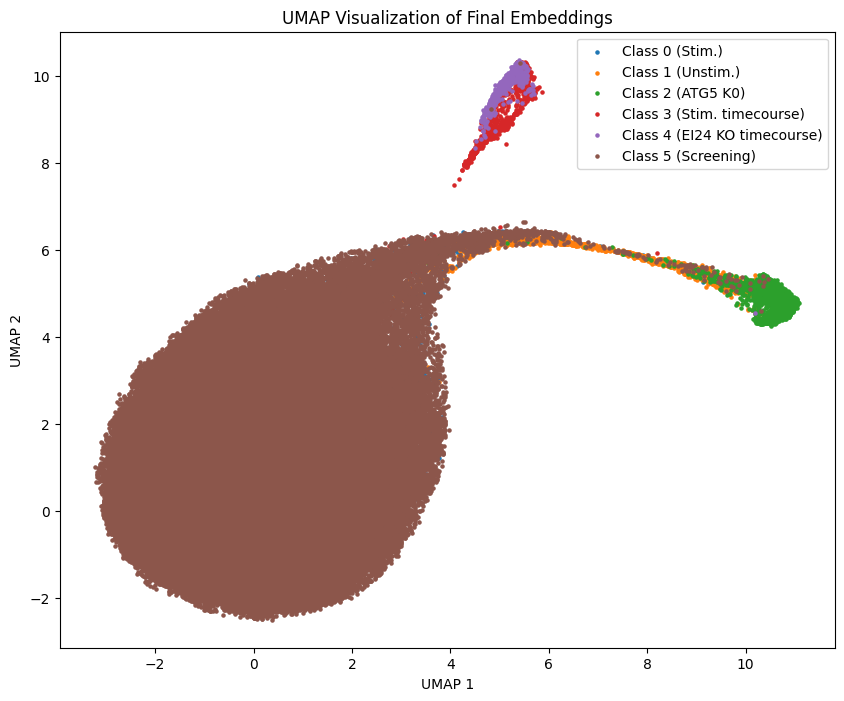

In [38]:
# Visualize UMAP
plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    # Select indices for each class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of Final Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

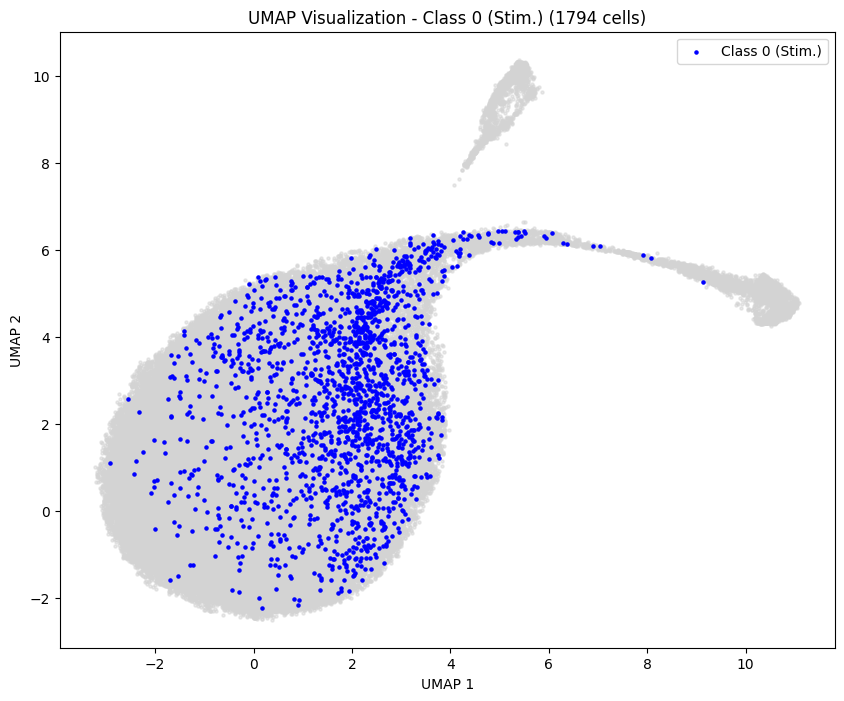

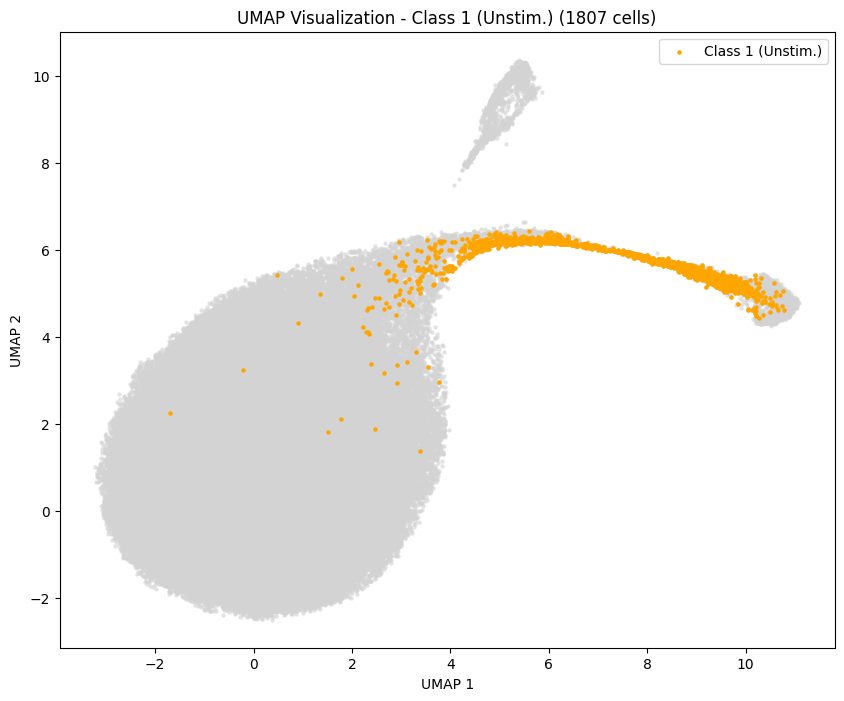

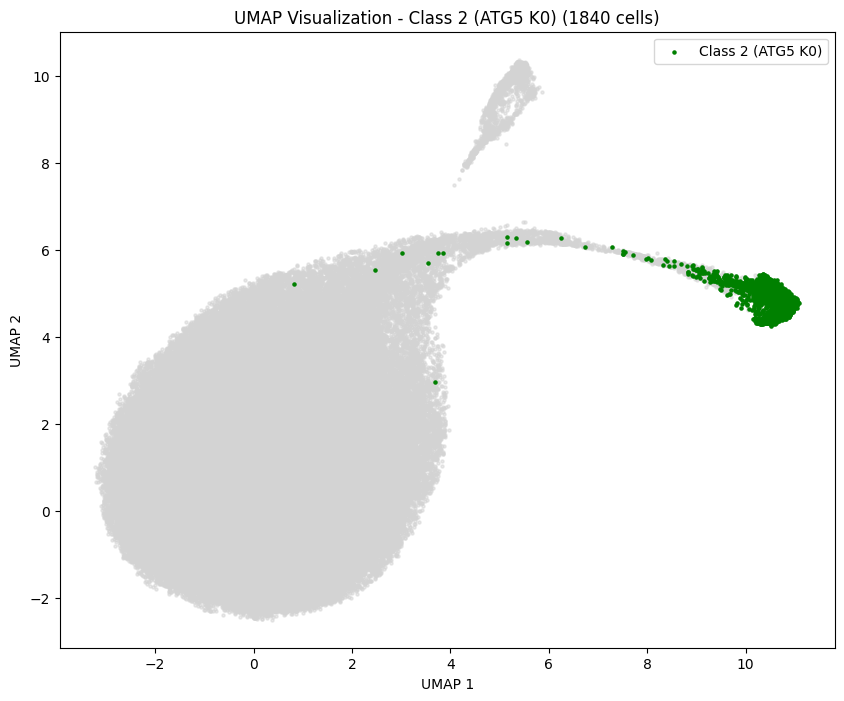

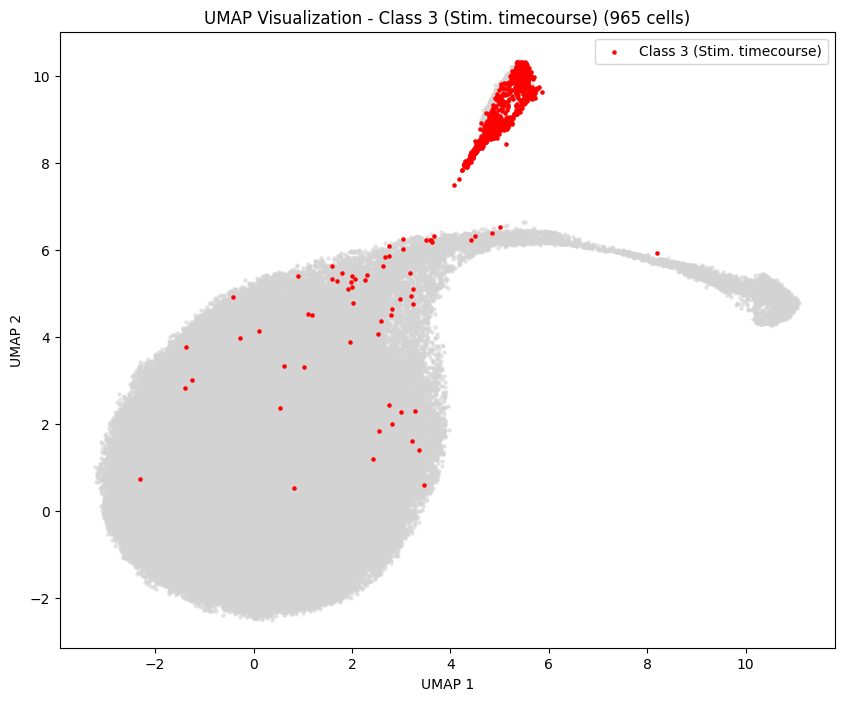

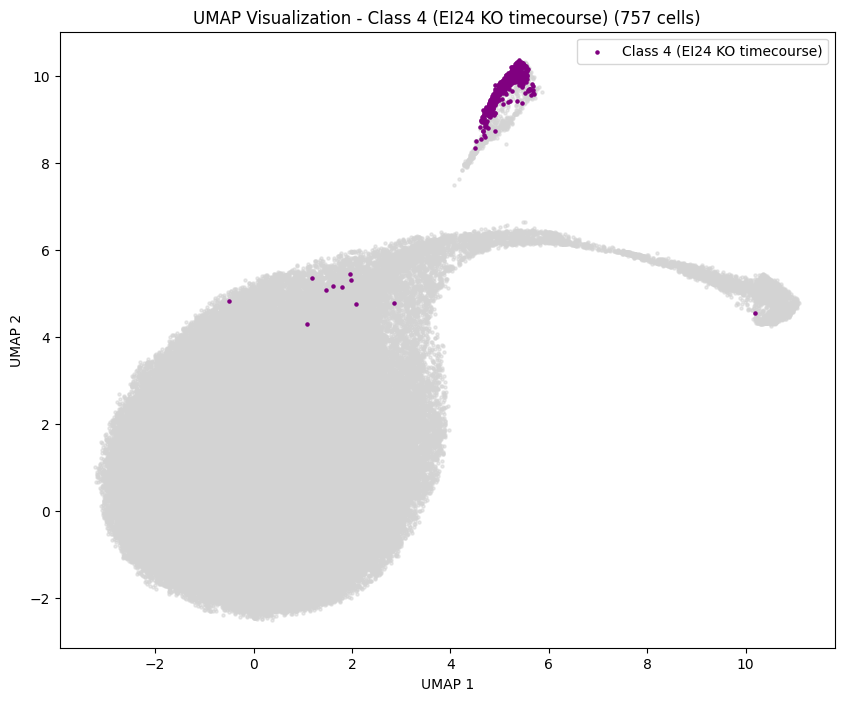

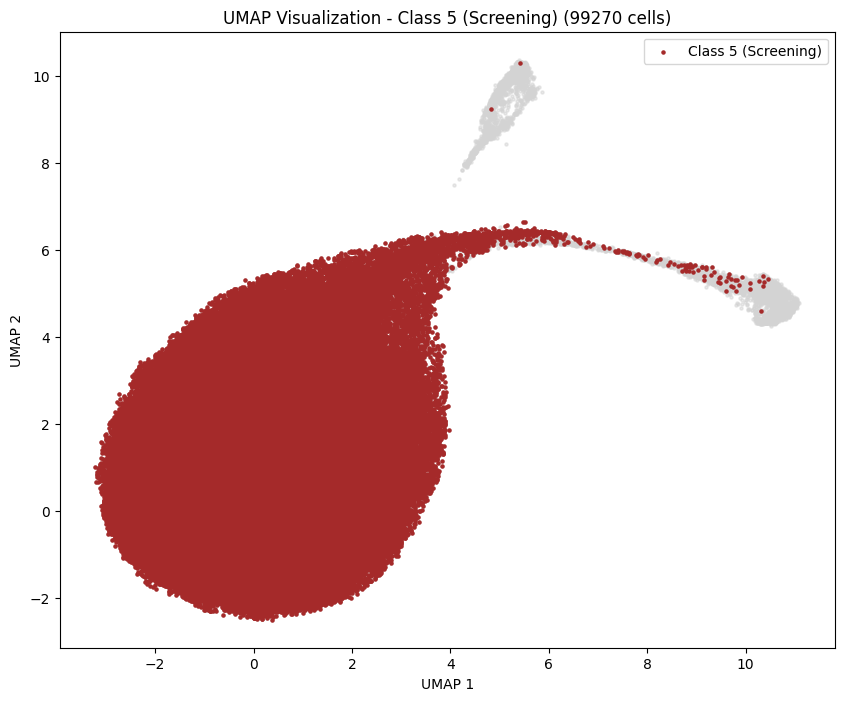

In [39]:
#Create separate UMAP plots for each class
for i, label in enumerate(class_labels):
    plt.figure(figsize=(10, 8))
    
    # Plot all classes in lightgray first
    for j in range(1, len(class_labels)):  # start from 1 to skip class 0
        idx = labels_list == j
        plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color='lightgray', alpha=0.5, s=5)
    
    # Plot the current class (i) in a distinct color
    idx = labels_list == i
    class_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']  # Add more if needed
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], color=class_colors[i], label=label, s=5)
    
    # Display the number of cells in the current class
    cell_count = np.sum(labels_list == i)
    plt.title(f"UMAP Visualization - {label} ({cell_count} cells)")
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.show()

In [40]:
class_labels = [
    "Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"
]

# Parameters for kNN and Outlier Detection
k = 10  # number of nearest neighbors
n = 5000  # number of outliers to find

# Extract the UMAP result and labels
x_coords = np.asarray(umap_result[:, 0])
y_coords = np.asarray(umap_result[:, 1])
labels = np.asarray(labels_list)
cell_ids_array = np.asarray(cell_ids_list, dtype=str)

# Identify screening cells (Class 5)
screening_idx = labels == 5
screening_coords = np.column_stack((x_coords[screening_idx], y_coords[screening_idx]))

# Find the dense cluster of screening cells (non-hit control) using kNN
nbrs = NearestNeighbors(n_neighbors=k).fit(screening_coords)
distances, _ = nbrs.kneighbors(screening_coords)

# Compute the mean distance to k nearest neighbors for each cell
avg_knn_dist = distances.mean(axis=1)

# Identify the top n outliers with the biggest kNN distances
outlier_indices = np.argsort(avg_knn_dist)[-n:]

# Get the cell IDs of the outliers
outlier_cell_ids = cell_ids_array[screening_idx][outlier_indices] 

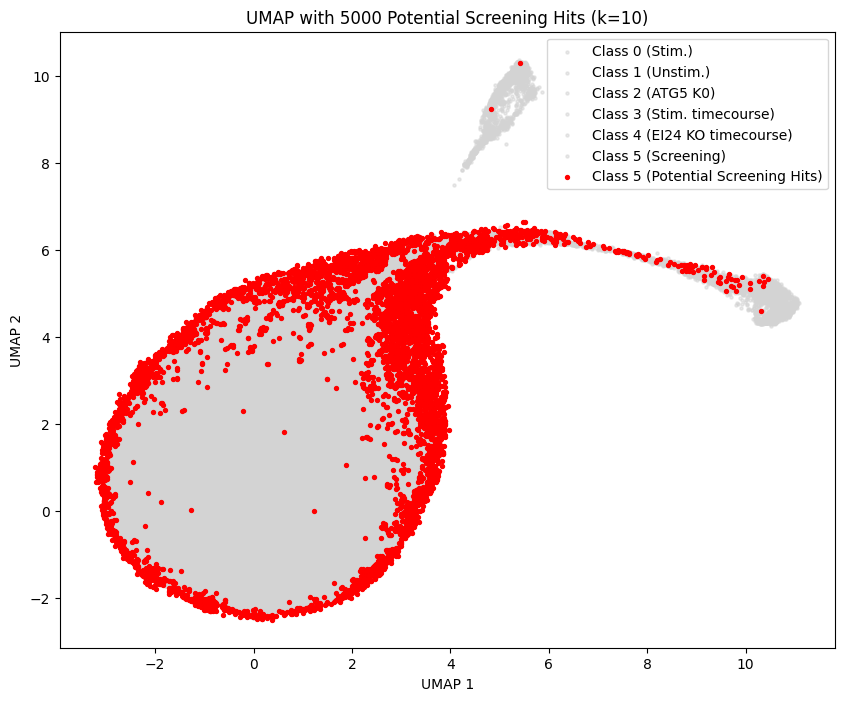

In [41]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all classes (including screening) in light grey
for i, label in enumerate(class_labels):  
    idx = labels == i
    plt.scatter(x_coords[idx], y_coords[idx], color='lightgrey', label=label, s=5, alpha=0.5)

# Plot Screening cells that are identified as potential hits using kNN in red
plt.scatter(screening_coords[outlier_indices, 0], screening_coords[outlier_indices, 1], 
            color='red', label="Class 5 (Potential Screening Hits)", s=8, edgecolors='red')
plt.legend()
plt.title(f"UMAP with {n} Potential Screening Hits (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.show()

In [42]:
# Save outlier cell IDs to a file
save_path = "./active_learning_output_files/blue_model_knn_screening_hits_old_LRZ_testset.txt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savetxt(save_path, outlier_cell_ids, fmt="%s")
print(f"Saved {len(outlier_cell_ids)} potential screening hits to {save_path}")

Saved 5000 potential screening hits to ./active_learning_output_files/blue_model_knn_screening_hits_old_LRZ_testset.txt


In [43]:
import pandas as pd
df = pd.read_csv("active_learning_autophagy21_classification_scores.csv")
df["Cell ID"] = df["Cell ID"].astype(str)  # Ensure Cell IDs are strings
df

,Cell ID,Autophagy On Score,Autophagy Off Score
0,409600,9.999976e-01,2.378960e-06
1,271446,9.999991e-01,9.431373e-07
2,371676,9.999878e-01,1.218928e-05
3,340348,9.999900e-01,1.002097e-05
4,31904,9.999991e-01,9.632774e-07
...,...,...,...
109995,85724,9.982374e-01,1.762557e-03
109996,121680,9.999870e-01,1.297279e-05
109997,433650,9.777784e-08,9.999999e-01
109998,355281,9.999907e-01,9.312190e-06


In [44]:
# Step 1: Convert to string for consistency
df["Cell ID"] = df["Cell ID"].astype(str)
cell_ids_str_list = list(map(str, cell_ids_list))

# Step 2: Ensure all cell IDs exist in df
df_unique = df.drop_duplicates(subset="Cell ID").copy()
existing_ids = set(df_unique["Cell ID"])
valid_cell_ids = [cid for cid in cell_ids_str_list if cid in existing_ids]

print(f"Original list length: {len(cell_ids_str_list)}")
print(f"Valid unique IDs found in df: {len(valid_cell_ids)}")
print(f"Shape of df_unique: {df_unique.shape}")

# Step 3: Subset in order
df_indexed = df_unique.set_index("Cell ID")
filtered_df_ordered = df_indexed.loc[valid_cell_ids].reset_index()

# Step 4: Sanity check
ordered_match = np.all(filtered_df_ordered['Cell ID'].values == np.array(valid_cell_ids))
print(f"Final filtered shape: {filtered_df_ordered.shape}")
print(f"Order matches cell_ids_list? {ordered_match}")

Original list length: 106433
Valid unique IDs found in df: 106433
Shape of df_unique: (106433, 3)
Final filtered shape: (106433, 3)
Order matches cell_ids_list? True


In [45]:
# Your class label names
class_labels = [
    "Class 0 (Stim.)", 
    "Class 1 (Unstim.)", 
    "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", 
    "Class 4 (EI24 KO timecourse)", 
    "Class 5 (Screening)"
]

# Add numeric class label (assuming labels_list is ordered to match)
filtered_df_ordered["class_label"] = labels_list

# Add readable class label using mapping
filtered_df_ordered["class_label_name"] = [class_labels[i] for i in labels_list]
filtered_df_ordered

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name
0,56802,1.204081e-07,1.000000,2,Class 2 (ATG5 K0)
1,407625,9.999980e-01,0.000002,5,Class 5 (Screening)
2,61478,9.995758e-01,0.000424,5,Class 5 (Screening)
3,10885,9.999783e-01,0.000022,5,Class 5 (Screening)
4,61776,9.999989e-01,0.000001,5,Class 5 (Screening)
...,...,...,...,...,...
106428,377757,9.998151e-01,0.000185,5,Class 5 (Screening)
106429,136790,9.999849e-01,0.000015,5,Class 5 (Screening)
106430,238117,9.999986e-01,0.000001,5,Class 5 (Screening)
106431,504322,9.999864e-01,0.000014,5,Class 5 (Screening)


In [46]:
count_df = filtered_df_ordered["class_label_name"].value_counts().reset_index()
count_df.columns = ["Class Label", "Cell Count"]
count_df

,Class Label,Cell Count
0,Class 5 (Screening),99270
1,Class 2 (ATG5 K0),1840
2,Class 1 (Unstim.),1807
3,Class 0 (Stim.),1794
4,Class 3 (Stim. timecourse),965
5,Class 4 (EI24 KO timecourse),757


In [47]:
# Check if 'Cell ID' has duplicates in df
cell_id_duplicates = df["Cell ID"].duplicated(keep=False)  # Marks all duplicates as True
duplicated_cell_ids = df[cell_id_duplicates]

# Print out duplicated cell IDs (if any)
print(duplicated_cell_ids)

       Cell ID  Autophagy On Score  Autophagy Off Score
44         476        1.436394e-03             0.998564
45      420700        1.073452e-07             1.000000
75         615        2.970107e-02             0.970299
81      217412        9.925733e-01             0.007427
107        483        9.978655e-01             0.002134
...        ...                 ...                  ...
109763    1087        1.045374e-02             0.989546
109787     894        6.431243e-05             0.999936
109814      72        6.509799e-01             0.349020
109850    1451        1.631395e-01             0.836861
109899     481        7.765298e-04             0.999224

[5898 rows x 3 columns]


In [48]:
# Step 1: Define the binning function based on Autophagy Off Score
def assign_bin(score):
    if score > 0.99999:
        return "bin 1 screening"
    elif score > 0.999:
        return "bin 2 screening"
    elif score > 0.9975:
        return "bin 3 screening"
    elif score > 0.995:
        return "bin 4 screening"
    elif score > 0.99:
        return "bin 5 screening"
    elif score > 0.98:
        return "bin 6 screening"
    else:
        return "not excised screening"

# Step 2: Apply the binning function for Class 5, and "other classes" elsewhere
filtered_df_ordered["screening_bin"] = filtered_df_ordered.apply(
    lambda row: assign_bin(row["Autophagy Off Score"]) if row["class_label"] == 5 else "other classes",
    axis=1
)

In [49]:
filtered_df_ordered

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin
0,56802,1.204081e-07,1.000000,2,Class 2 (ATG5 K0),other classes
1,407625,9.999980e-01,0.000002,5,Class 5 (Screening),not excised screening
2,61478,9.995758e-01,0.000424,5,Class 5 (Screening),not excised screening
3,10885,9.999783e-01,0.000022,5,Class 5 (Screening),not excised screening
4,61776,9.999989e-01,0.000001,5,Class 5 (Screening),not excised screening
...,...,...,...,...,...,...
106428,377757,9.998151e-01,0.000185,5,Class 5 (Screening),not excised screening
106429,136790,9.999849e-01,0.000015,5,Class 5 (Screening),not excised screening
106430,238117,9.999986e-01,0.000001,5,Class 5 (Screening),not excised screening
106431,504322,9.999864e-01,0.000014,5,Class 5 (Screening),not excised screening


In [50]:
# Count the number of instances in each bin
bin_counts = filtered_df_ordered["screening_bin"].value_counts().sort_index()

# Display the counts
print(bin_counts)

bin 1 screening            126
bin 2 screening            476
bin 3 screening            159
bin 4 screening            107
bin 5 screening            120
bin 6 screening            117
not excised screening    98165
other classes             7163
Name: screening_bin, dtype: int64


In [51]:
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

%matplotlib inline

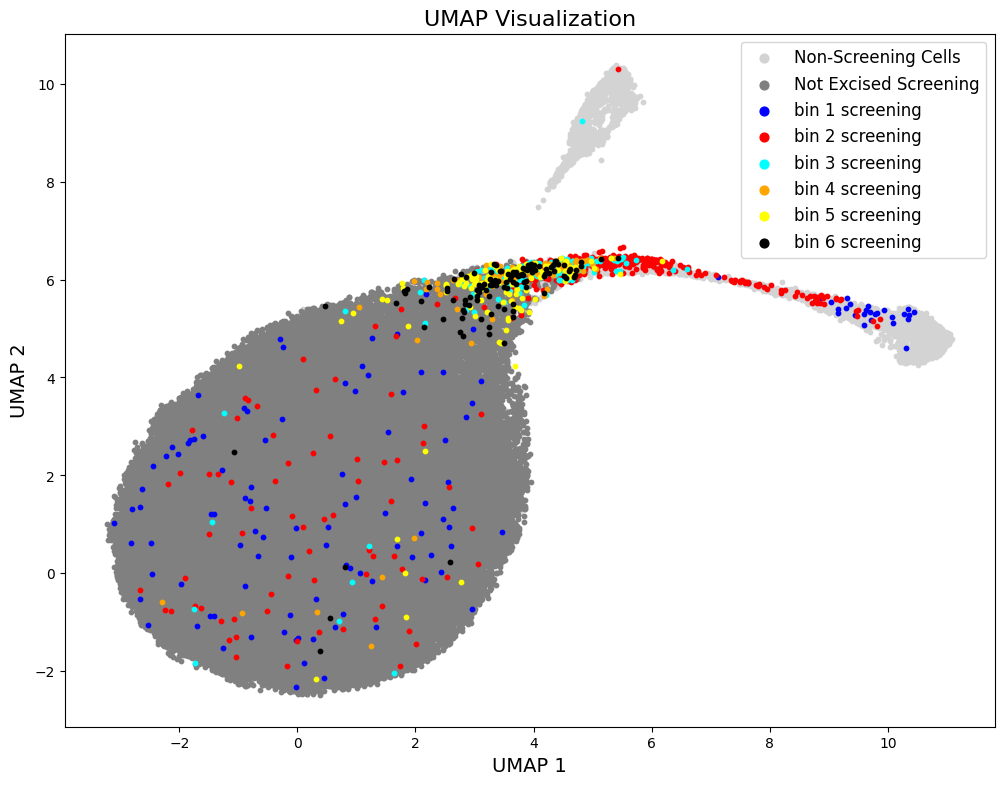

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define the bin colors as you have them
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

# Increase the figure size for a larger plot
plt.figure(figsize=(12, 9))

# Step 1: First, plot all non-screening cells in lightgrey
non_screening_mask = filtered_df_ordered["class_label"] != 5
plt.scatter(umap_result[non_screening_mask, 0], umap_result[non_screening_mask, 1], 
            color='lightgrey', label='Non-Screening Cells', s=10)

# Step 2: Plot all screening cells with "not excised screening" in light green
not_excised_mask = (filtered_df_ordered["class_label"] == 5) & (filtered_df_ordered["screening_bin"] == "not excised screening")
plt.scatter(umap_result[not_excised_mask, 0], umap_result[not_excised_mask, 1], 
            color='grey', label='Not Excised Screening', s=10)

# Step 3: Plot screening bins with their respective colors
for bin_label, color in bin_colors.items():
    if bin_label != "not excised screening" and bin_label != "other classes":
        bin_mask = (filtered_df_ordered["screening_bin"] == bin_label)
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1], 
                    color=color, label=bin_label, s=10)

# Add labels, title, and legend
plt.title('UMAP Visualization', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

# Adjust the legend, increase markerscale for larger dots
plt.legend(loc='best', fontsize=12, markerscale=2)


# Show the plot
plt.show()

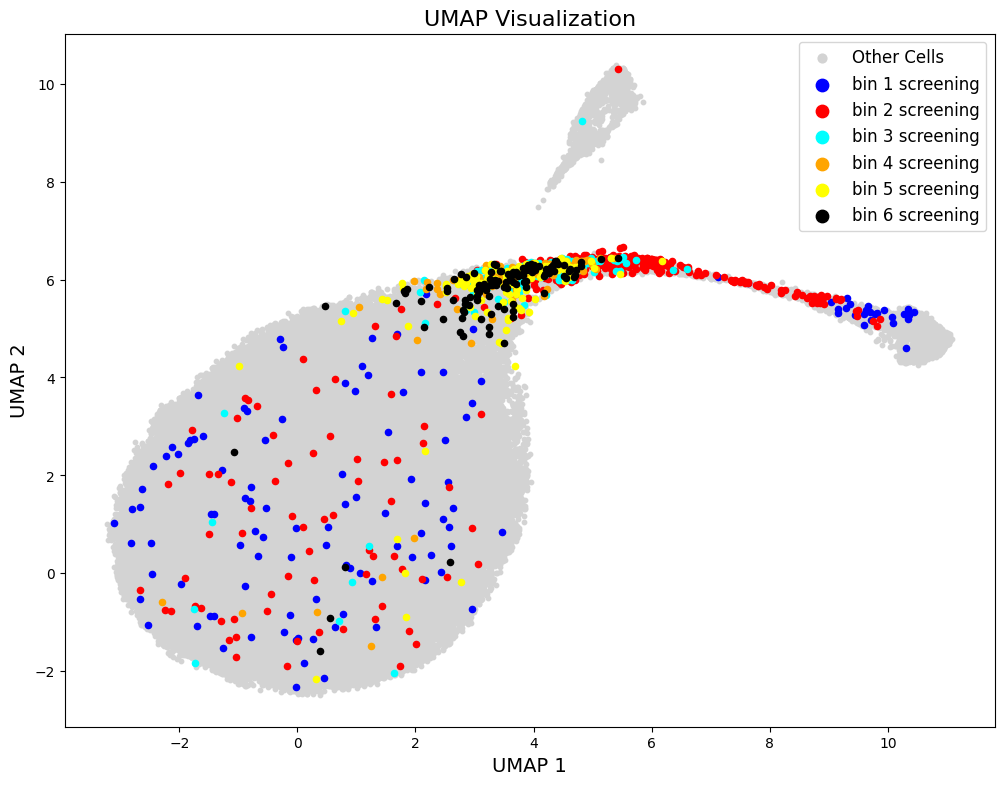

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define the bin colors as you have them
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "lightgreen",
    "other classes": "lightgrey"
}

# Increase the figure size for a larger plot
plt.figure(figsize=(12, 9))

# Step 1: Plot all cells in light grey first (non-relevant ones will be grey)
plt.scatter(umap_result[:, 0], umap_result[:, 1], 
            color='lightgrey', s=10, label='Other Cells')

# Step 2: Plot screening bins with their respective colors (only relevant cells)
for bin_label, color in bin_colors.items():
    if bin_label != "not excised screening" and bin_label != "other classes":
        bin_mask = filtered_df_ordered["screening_bin"] == bin_label
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1], 
                    color=color, label=bin_label, s=20)  # Slightly larger markers for bins

# Add labels, title, and legend
plt.title('UMAP Visualization', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

# Adjust the legend, increase markerscale for larger dots
plt.legend(loc='best', fontsize=12, markerscale=2)

# Show the plot
plt.show()

In [54]:
# Load the list of CSH cells from the text file
with open('./active_learning_output_files/blue_model_knn_screening_hits_old_LRZ_testset.txt') as f:
    csh_cells = set(line.strip() for line in f.readlines())


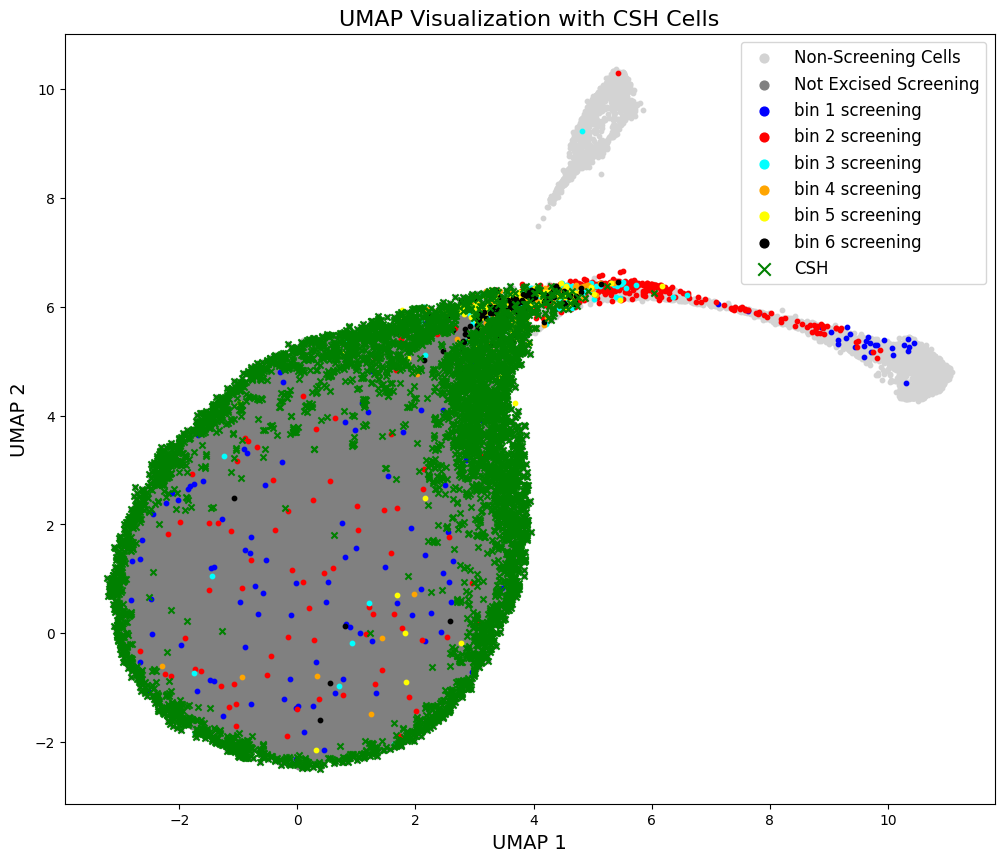

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define the bin colors as you have them
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

# Increase the figure size for a larger plot
plt.figure(figsize=(12, 10))

# Step 1: First, plot all non-screening cells in lightgrey
non_screening_mask = filtered_df_ordered["class_label"] != 5
plt.scatter(umap_result[non_screening_mask, 0], umap_result[non_screening_mask, 1], 
            color='lightgrey', label='Non-Screening Cells', s=10)

# Step 2: Plot all screening cells with "not excised screening" in light green
not_excised_mask = (filtered_df_ordered["class_label"] == 5) & (filtered_df_ordered["screening_bin"] == "not excised screening")
plt.scatter(umap_result[not_excised_mask, 0], umap_result[not_excised_mask, 1], 
            color='grey', label='Not Excised Screening', s=10)

# Step 3: Plot screening bins with their respective colors
for bin_label, color in bin_colors.items():
    if bin_label != "not excised screening" and bin_label != "other classes":
        bin_mask = (filtered_df_ordered["screening_bin"] == bin_label)
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1], 
                    color=color, label=bin_label, s=10)

# Step 4: Find CSH cells within "not excised screening" and plot them with an "x" marker in green
csh_mask = (filtered_df_ordered["class_label"] == 5) & (filtered_df_ordered["screening_bin"] == "not excised screening") & \
           (filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells))
plt.scatter(umap_result[csh_mask, 0], umap_result[csh_mask, 1], 
            color='green', marker='x', label='CSH', s=20)  # "x" marker with larger size for visibility

# Add labels, title, and legend
plt.title('UMAP Visualization with CSH Cells', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

# Adjust the legend, increase markerscale for larger dots
plt.legend(loc='best', fontsize=12, markerscale=2)

# Show the plot
plt.show()

Total number of filtered_df entries: 106433

Cell Counts per Bin:
not excised screening    98165
other classes             7163
bin 2 screening            476
bin 3 screening            159
bin 1 screening            126
bin 5 screening            120
bin 6 screening            117
bin 4 screening            107
Name: screening_bin, dtype: int64

Cell Percentages per Bin:
not excised screening    92.231733
other classes             6.730056
bin 2 screening           0.447230
bin 3 screening           0.149390
bin 1 screening           0.118384
bin 5 screening           0.112747
bin 6 screening           0.109928
bin 4 screening           0.100533
Name: screening_bin, dtype: float64


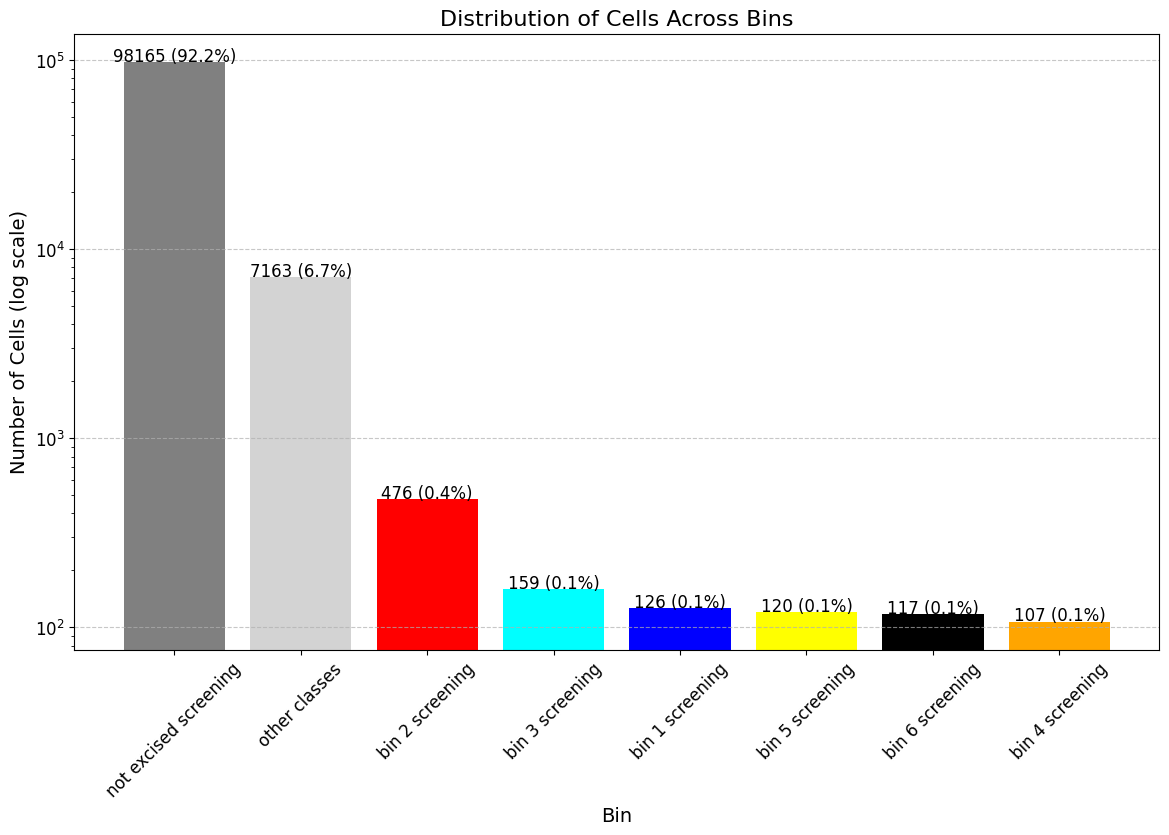

In [56]:
import matplotlib.pyplot as plt

# Step 1: Count occurrences of each bin
bin_counts = filtered_df_ordered["screening_bin"].value_counts()

# Step 2: Compute percentages
total_cells = len(filtered_df_ordered)
bin_percentages = (bin_counts / total_cells) * 100

# Step 3: Print results
print(f"Total number of filtered_df entries: {total_cells}\n")
print("Cell Counts per Bin:")
print(bin_counts)
print("\nCell Percentages per Bin:")
print(bin_percentages)

# Step 4: Create stacked bar plot
plt.figure(figsize=(14, 8))

# Step 5: Plot the stacked bar chart with bin colors
bars = plt.bar(bin_counts.index, bin_counts.values, 
               color=[bin_colors.get(bin, 'lightgrey') for bin in bin_counts.index])

# Step 6: Add labels on top of bars (count + percentage)
for bar, count, percentage in zip(bars, bin_counts.values, bin_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f"{count} ({percentage:.1f}%)", 
             ha="center", fontsize=12)

# Step 7: Formatting
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Number of Cells (log scale)", fontsize=14)
plt.title("Distribution of Cells Across Bins", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set Y-axis to log scale
plt.yscale("log")

# Step 8: Save the plot (optional)
# output_path = "./active_learning_output_files/bin_distribution.png"
# plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()


In [58]:
# Step 0: Load CSH cell list
with open('./active_learning_output_files/blue_model_knn_screening_hits_old_LRZ_testset.txt') as f:
    csh_cells = set(line.strip() for line in f.readlines()) # not just csh cells but all kNN 5000 cells!!!


excised_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening", 
                "bin 4 screening", "bin 5 screening", "bin 6 screening"]

# Step 1: Count how many CSH cells fall into each excised bin
csh_excised_bin_counts = filtered_df_ordered[
    filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells) &
    filtered_df_ordered["screening_bin"].isin(excised_bins)
]["screening_bin"].value_counts()

# Step 2: Count "CSH" in not-excised bin as before
csh_not_excised_count = filtered_df_ordered[
    (filtered_df_ordered["class_label"] == 5) &
    (filtered_df_ordered["screening_bin"] == "not excised screening") &
    (filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells))
].shape[0]

In [48]:
len(csh_cells)

5000

In [45]:
csh_excised_bin_counts

bin 2 screening    271
bin 3 screening     66
bin 5 screening     55
bin 4 screening     47
bin 6 screening     44
bin 1 screening     35
Name: screening_bin, dtype: int64

In [44]:
csh_not_excised_count

4482

In [49]:
# Step 3: Create combined DataFrame for plotting
bar_data = pd.DataFrame({
    "Bin": target_bins,
    "Count": [csh_excised_bin_counts.get(bin_label, 0) for bin_label in target_bins[:-1]] + [csh_not_excised_count]
})


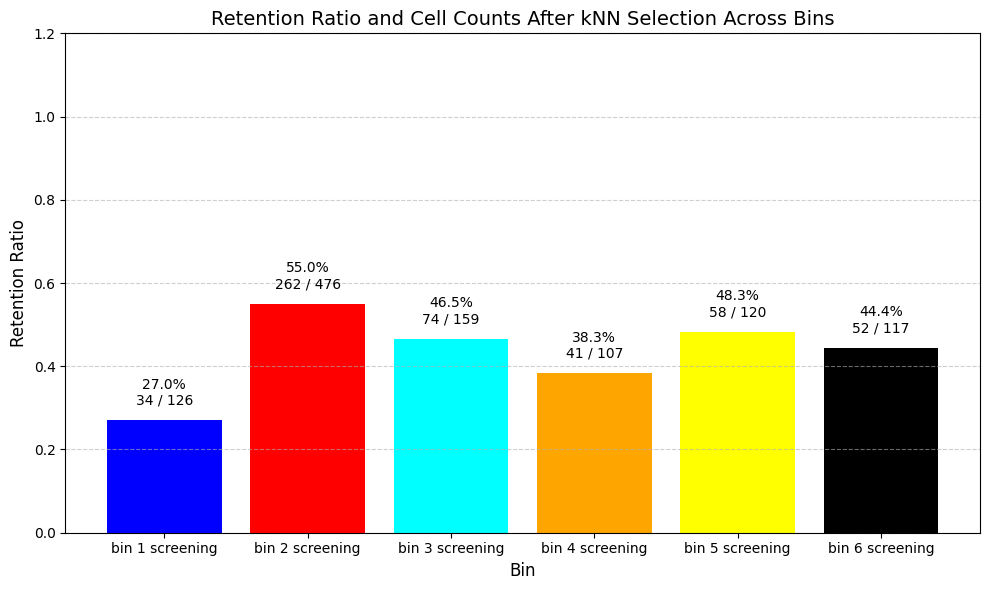

In [62]:
import matplotlib.pyplot as plt
import pandas as pd


plot_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black"
}

import matplotlib.pyplot as plt

# Step 1: Your original and after-kNN counts
original_counts = {
    "bin 1 screening": 126,
    "bin 2 screening": 476,
    "bin 3 screening": 159,
    "bin 4 screening": 107,
    "bin 5 screening": 120,
    "bin 6 screening": 117
}

after_knn_counts = {
    "bin 1 screening": csh_excised_bin_counts.get("bin 1 screening", 0),
    "bin 2 screening": csh_excised_bin_counts.get("bin 2 screening", 0),
    "bin 3 screening": csh_excised_bin_counts.get("bin 3 screening", 0),
    "bin 4 screening": csh_excised_bin_counts.get("bin 4 screening", 0),
    "bin 5 screening": csh_excised_bin_counts.get("bin 5 screening", 0),
    "bin 6 screening": csh_excised_bin_counts.get("bin 6 screening", 0)
}

bins = list(original_counts.keys())
ratios = [after_knn_counts[b] / original_counts[b] if original_counts[b] > 0 else 0 for b in bins]

# Step 2: Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(bins, ratios, color=[plot_colors.get(b, 'gray') for b in bins])

# Step 3: Add labels: ratio + raw counts
for bar, bin_label in zip(bars, bins):
    after = after_knn_counts[bin_label]
    before = original_counts[bin_label]
    ratio = after / before if before > 0 else 0

    label_text = f"{ratio * 100:.1f}%\n{after} / {before}"

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.03,
        label_text,
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 4: Final touches
plt.title("Retention Ratio and Cell Counts After kNN Selection Across Bins", fontsize=14)
plt.xlabel("Bin", fontsize=12)
plt.ylabel("Retention Ratio", fontsize=12)
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [64]:
filtered_df_ordered["class_label_name"].value_counts()

Class 5 (Screening)             99270
Class 2 (ATG5 K0)                1840
Class 1 (Unstim.)                1807
Class 0 (Stim.)                  1794
Class 3 (Stim. timecourse)        965
Class 4 (EI24 KO timecourse)      757
Name: class_label_name, dtype: int64

In [63]:
# Step 1: Filter the dataframe to only include rows for bins 1-6
valid_bins = ['bin 1 screening', 'bin 2 screening', 'bin 3 screening', 'bin 4 screening', 'bin 5 screening', 'bin 6 screening']
filtered_bins_df = filtered_df_ordered[filtered_df_ordered["screening_bin"].isin(valid_bins)]

# Step 2: Count occurrences of each bin (bins 1-6)
bin_counts = filtered_bins_df["screening_bin"].value_counts()

# Step 3: Compute the total number of cells in the filtered dataframe (only bins 1-6)
total_cells_in_bins = bin_counts.sum()  # Sum of the counts for bins 1-6

# Step 4: Compute percentages for each bin
total_cells = len(filtered_bins_df)  # Total number of valid cells in bins 1-6
bin_percentages = (bin_counts / total_cells) * 100

# Step 5: Combine counts and percentages into a single dataframe for easy display
bin_summary = pd.DataFrame({
    'Cell Count': bin_counts,
    'Percentage (%)': bin_percentages
})

# Step 6: Print results
print(f"Total number of filtered cells in bins 1-6: {total_cells_in_bins}\n")
print("Cell Counts and Percentages per Bin:")
print(bin_summary)

Total number of filtered cells in bins 1-6: 1105

Cell Counts and Percentages per Bin:
                 Cell Count  Percentage (%)
bin 2 screening         476       43.076923
bin 3 screening         159       14.389140
bin 1 screening         126       11.402715
bin 5 screening         120       10.859729
bin 6 screening         117       10.588235
bin 4 screening         107        9.683258


In [56]:
excised_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening", 
                "bin 4 screening", "bin 5 screening", "bin 6 screening"]

# Get only the CSH cells that are in excised bins
excised_df = filtered_df_ordered[
    filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells) &
    filtered_df_ordered["screening_bin"].isin(excised_bins)
].copy()

# Count these rows
print(f"Total cells in excised bins (bin 1–6): {excised_df.shape[0]}")

Total cells in excised bins (bin 1–6): 518


p-value: 1.0
The p-value is not significant, meaning the active learning approach is not significantly different from random.


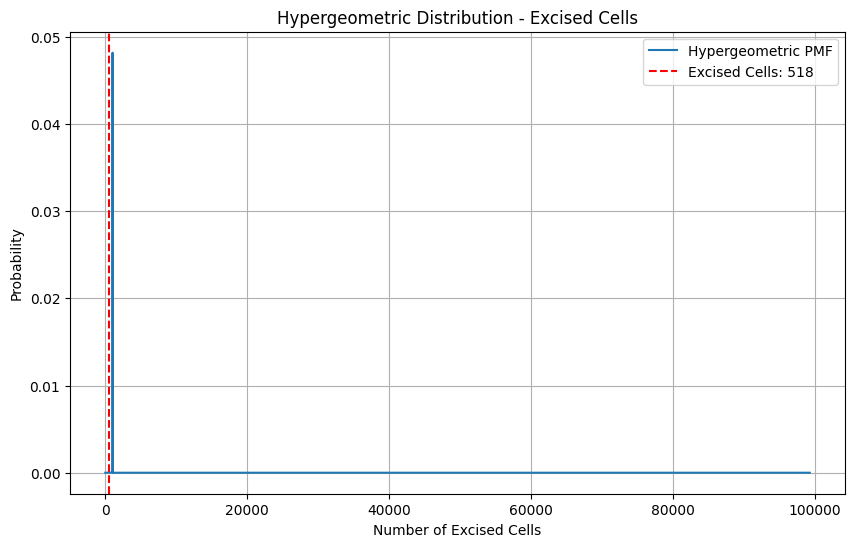

In [118]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Given values
total_cells = 106433       # Total number of cells
total_screening_cells = 99270  # Total number of screening cells
total_with_bin_info = 1105    # Total number of cells with bin information
total_excised_cells = 518    # Total number of excised cells in active learning approach

# Perform hypergeometric test
# Hypergeometric test: P(X=k) = (comb(K, k) * comb(N-K, M-k)) / comb(N, M)
# Where:
#   N = total_cells (106433)
#   M = total_screening_cells (99270)
#   K = total_with_bin_info (1105)
#   k = total_excised_cells (518)

p_value = stats.hypergeom.sf(total_excised_cells - 1, total_cells, total_with_bin_info, total_screening_cells)

# Output p-value
print(f"p-value: {p_value}")

# Determine if p-value is significant
alpha = 0.05
if p_value < alpha:
    print("The p-value is significant, meaning the active learning approach is significantly different from random.")
else:
    print("The p-value is not significant, meaning the active learning approach is not significantly different from random.")

# Now let's plot the hypergeometric distribution to visualize the distribution and the p-value
x = np.arange(0, total_screening_cells + 1)
hypergeom_pmf = stats.hypergeom.pmf(x, total_cells, total_with_bin_info, total_screening_cells)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(x, hypergeom_pmf, label="Hypergeometric PMF")
plt.axvline(total_excised_cells, color='r', linestyle='dashed', label=f'Excised Cells: {total_excised_cells}')
plt.title('Hypergeometric Distribution - Excised Cells')
plt.xlabel('Number of Excised Cells')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)

# Add a horizontal line for the significance threshold (optional)
plt.fill_between(x, 0, hypergeom_pmf, where=(x <= total_excised_cells), color='skyblue', alpha=0.5)

plt.show()

In [67]:
from scipy.stats import hypergeom

# Constants
total_cells = 106433
total_screening_cells = 99270

# Bin names you're interested in
excised_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening",
                "bin 4 screening", "bin 5 screening", "bin 6 screening"]

# Results dictionary to store p-values
bin_significance_results = []

# Loop over each bin
for bin_label in excised_bins:
    # Total cells that fall into this bin (from original dataset)
    num_in_bin = filtered_df_ordered[filtered_df_ordered["screening_bin"] == bin_label].shape[0]

    # How many of these were selected by active learning (CSH cells)
    num_csh_in_bin = excised_df[excised_df["screening_bin"] == bin_label].shape[0]

    # Hypergeometric test
    p_val = hypergeom.sf(num_csh_in_bin - 1, total_cells, num_in_bin, total_screening_cells)

    bin_significance_results.append({
        "Bin": bin_label,
        "Bin Total": num_in_bin,
        "CSH Selected": num_csh_in_bin,
        "p-value": p_val
    })

# Convert to DataFrame for nicer viewing
import pandas as pd
results_df = pd.DataFrame(bin_significance_results)
results_df["Significant (p < 0.05)"] = results_df["p-value"] < 0.05

# Print nicely
print(results_df.to_string(index=False))

            Bin  Bin Total  CSH Selected  p-value  Significant (p < 0.05)
bin 1 screening        126            35      1.0                   False
bin 2 screening        476           271      1.0                   False
bin 3 screening        159            66      1.0                   False
bin 4 screening        107            47      1.0                   False
bin 5 screening        120            55      1.0                   False
bin 6 screening        117            44      1.0                   False


In [57]:
excised_df

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin
214,407991,0.000554,0.999445,5,Class 5 (Screening),bin 2 screening
375,497108,0.000184,0.999816,5,Class 5 (Screening),bin 2 screening
398,363720,0.008545,0.991455,5,Class 5 (Screening),bin 5 screening
406,496705,0.002898,0.997102,5,Class 5 (Screening),bin 4 screening
426,383069,0.002577,0.997423,5,Class 5 (Screening),bin 4 screening
...,...,...,...,...,...,...
104895,494333,0.006594,0.993406,5,Class 5 (Screening),bin 5 screening
105226,267813,0.000931,0.999069,5,Class 5 (Screening),bin 2 screening
106219,498686,0.000437,0.999563,5,Class 5 (Screening),bin 2 screening
106222,383060,0.000015,0.999985,5,Class 5 (Screening),bin 2 screening


In [58]:
# Save excised_df to CSV
output_path = './active_learning_output_files/Blue_model_excised_cells_old_LRZ.csv'
excised_df.to_csv(output_path, index=False)
print(f"Excised dataframe saved to {output_path}")

Excised dataframe saved to ./active_learning_output_files/Blue_model_excised_cells_old_LRZ.csv


In [66]:
# Read the excised_df from the CSV file
input_path = './active_learning_output_files/Blue_model_excised_cells_old_LRZ.csv'
excised_df = pd.read_csv(input_path)
excised_df

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin
0,407991,0.000554,0.999445,5,Class 5 (Screening),bin 2 screening
1,497108,0.000184,0.999816,5,Class 5 (Screening),bin 2 screening
2,363720,0.008545,0.991455,5,Class 5 (Screening),bin 5 screening
3,496705,0.002898,0.997102,5,Class 5 (Screening),bin 4 screening
4,383069,0.002577,0.997423,5,Class 5 (Screening),bin 4 screening
...,...,...,...,...,...,...
513,494333,0.006594,0.993406,5,Class 5 (Screening),bin 5 screening
514,267813,0.000931,0.999069,5,Class 5 (Screening),bin 2 screening
515,498686,0.000437,0.999563,5,Class 5 (Screening),bin 2 screening
516,383060,0.000015,0.999985,5,Class 5 (Screening),bin 2 screening


In [34]:
import matplotlib.pyplot as plt
import os

def visualize_csh_images_from_filtered_df(filtered_df, data_loader, save_path="./active_learning_output_files/csh_images_filtered.png"):
    """
    Visualizes 5 CSH cell images from `filtered_df` and saves the figure.
    
    Args:
        filtered_df (pd.DataFrame): DataFrame containing the filtered cells (with 'Bin' and 'Cell ID').
        data_loader (DataLoader): PyTorch DataLoader containing images, labels, and cell IDs.
        save_path (str): Path to save the output image.
    """
    # Filter "CSH" cells from the filtered_df
    csh_cell_ids = filtered_df[filtered_df["Bin"] == "CSH"]["Cell ID"].unique()[:5]
    
    if csh_cell_ids.size == 0:  # Check if the array is empty
        print("No CSH cell images to visualize in the filtered data.")
        return

    # Convert cell IDs to strings for comparison
    csh_cell_ids = set(str(cid) for cid in csh_cell_ids)
    images_to_plot = []

    # Collect matching images from the DataLoader
    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            cid = str(cell_ids[i].item())
            if cid in csh_cell_ids:
                image_data = images[i].cpu().numpy()
                images_to_plot.append((cid, image_data))

                # Stop once we have 5 images
                if len(images_to_plot) >= 5:
                    break
        if len(images_to_plot) >= 5:
            break

    # Plot
    num_images = len(images_to_plot)
    cols = min(5, num_images)
    rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1)  # Flatten for consistency

    for ax, (cid, img_data) in zip(axes, images_to_plot):
        num_channels = img_data.shape[0]
        if num_channels == 1:
            ax.imshow(img_data[0], cmap="viridis")
        else:
            ax.imshow(np.moveaxis(img_data, 0, -1))  # (C, H, W) -> (H, W, C)

        ax.set_title(f"Cell ID: {cid}", fontsize=10)
        ax.axis("off")

    # Hide unused axes
    for ax in axes[len(images_to_plot):]:
        ax.axis("off")

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    #plt.savefig(save_path, dpi=300)
    #print(f"Saved CSH cell images from filtered_df to {save_path}")
    plt.show()

In [62]:
# Subset filtered_df_ordered to only include CSH cells
csh_df_for_images = filtered_df_ordered[
    (filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells)) &
    (filtered_df_ordered["screening_bin"] == "not excised screening")
].copy()

# Add a column for plotting consistency
csh_df_for_images["Bin"] = "CSH"

Saved CSH cell images from filtered_df to ./active_learning_output_files/csh_images_filtered.png


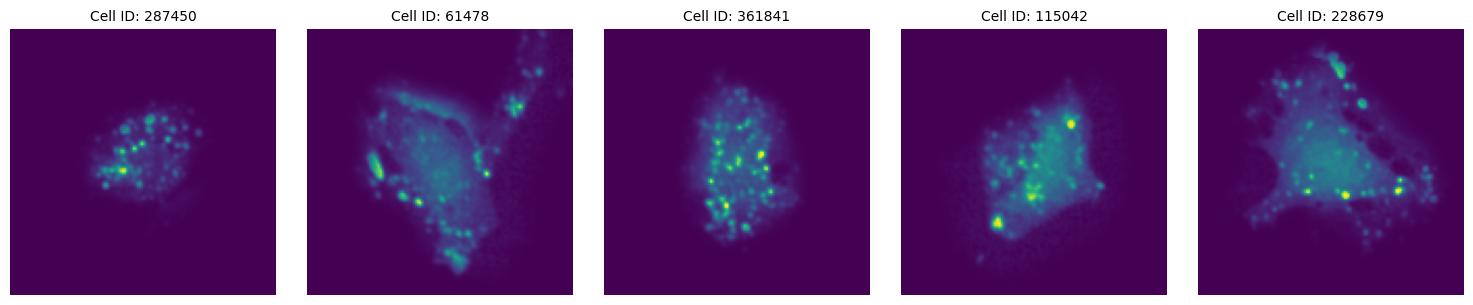

In [63]:
visualize_csh_images_from_filtered_df(
    filtered_df=csh_df_for_images,
    data_loader=test_data_loader
)

### Orange model first loop


output_dim=100

In [3]:
# Read the CSV file 
import pandas as pd
ground_truth_df = pd.read_csv("/dss/dsshome1/0F/di93quv/Niklas_inputs/simulated_active_learning/final_df_reduced.csv", index_col=0)

In [4]:
# Replace the row names (index) to include spaces, e.g., 'bin 1', 'bin 2', etc.
ground_truth_df.index = [f"bin {i+1}" for i in range(len(ground_truth_df))]

# Print the first few rows to verify
ground_truth_df

# ground_truth_df.to_csv("updated_final_df_reduced.csv")

,AGAGCGCGCTCAGAAGCGAA,CATCTAGGAGCATCTACCCA,AGTGGAACTTGCCTGTGCTG,CAGTATCCAAACGGGCTCTG,CTTGCCCTAAAGTAAAGTAC,CTTGGCGGTCCACATTGCAA,GAATAACCAAATGCAGCGGA,TTGTTAGGGAGGCTAATCCA,CTTCACATGTATGCTCATCG,CTTGAAAGACTCGAGTGTGT,...,AGCACGTAATGTCCGTGGAT,GGGGAAGTAACGGATCACGT,CAGGGACAAGCACTTACGCA,GAGCTGAAGCAGTGGTACAA,GCTGCGAGAAGAAACCAACG,AAGACCCTGTTAGCCATCGG,CACCGTACAGATCAACGTGA,GCGGTGATTGTACACATCGA,AGGCTGCAGAACATAAGACA,AGTGACATGTACAGCCACAT
bin 1,0.000749,0.041151,0.020777,0.020959,0.017536,0.016980,0.014172,0.010241,0.009149,0.009043,...,0.000523,0.000000,0.000000e+00,0.000000,0.000297,1.164600e-04,0.000000e+00,0.000000e+00,0.000000,0.000000
bin 2,1.000000,0.007713,0.007925,0.004914,0.002464,0.004502,0.002635,0.001897,0.002006,0.002738,...,0.002470,0.000000,0.000000e+00,0.000000,0.000000,2.331100e-03,0.000000e+00,0.000000e+00,0.000000,0.000000
bin 3,0.000000,0.001373,0.003010,0.001908,0.000000,0.001939,0.000579,0.000580,0.001342,0.001373,...,0.000000,0.002354,2.346073e-03,0.002418,0.000000,0.000000e+00,0.000000e+00,2.288554e-03,0.000000,0.000000
bin 4,0.000000,0.000650,0.001072,0.000555,0.000000,0.002656,0.000897,0.000000,0.000000,0.001121,...,0.000272,0.000000,4.362724e-07,0.000000,0.000000,0.000000e+00,0.000000e+00,4.362724e-07,0.002283,0.000000
bin 5,0.000000,0.002454,0.001062,0.001802,0.000535,0.000501,0.000976,0.000000,0.000558,0.000000,...,0.000000,0.000000,0.000000e+00,0.000417,0.002362,0.000000e+00,2.297496e-03,0.000000e+00,0.000000,0.002323
bin 6,0.000000,0.000450,0.000134,0.000997,0.000885,0.000960,0.000262,0.000910,0.001125,0.000216,...,0.000000,0.000000,0.000000e+00,0.000185,0.000000,5.217257e-07,9.330594e-07,0.000000e+00,0.000000,0.000471


In [5]:
# Read the excised_df from the CSV file
input_path = './active_learning_output_files/Blue_model_excised_cells_old_LRZ.csv'
excised_df = pd.read_csv(input_path)
excised_df

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin
0,407991,0.000554,0.999445,5,Class 5 (Screening),bin 2 screening
1,497108,0.000184,0.999816,5,Class 5 (Screening),bin 2 screening
2,363720,0.008545,0.991455,5,Class 5 (Screening),bin 5 screening
3,496705,0.002898,0.997102,5,Class 5 (Screening),bin 4 screening
4,383069,0.002577,0.997423,5,Class 5 (Screening),bin 4 screening
...,...,...,...,...,...,...
513,494333,0.006594,0.993406,5,Class 5 (Screening),bin 5 screening
514,267813,0.000931,0.999069,5,Class 5 (Screening),bin 2 screening
515,498686,0.000437,0.999563,5,Class 5 (Screening),bin 2 screening
516,383060,0.000015,0.999985,5,Class 5 (Screening),bin 2 screening


In [6]:
excised_df["screening_bin"] = excised_df["screening_bin"].str.replace(" screening", "", regex=False)
excised_df

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin
0,407991,0.000554,0.999445,5,Class 5 (Screening),bin 2
1,497108,0.000184,0.999816,5,Class 5 (Screening),bin 2
2,363720,0.008545,0.991455,5,Class 5 (Screening),bin 5
3,496705,0.002898,0.997102,5,Class 5 (Screening),bin 4
4,383069,0.002577,0.997423,5,Class 5 (Screening),bin 4
...,...,...,...,...,...,...
513,494333,0.006594,0.993406,5,Class 5 (Screening),bin 5
514,267813,0.000931,0.999069,5,Class 5 (Screening),bin 2
515,498686,0.000437,0.999563,5,Class 5 (Screening),bin 2
516,383060,0.000015,0.999985,5,Class 5 (Screening),bin 2


In [68]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return dataset, data_loader  # Return both dataset and DataLoader

# Load the balanced test dataset
dataset, test_data_loader = load_dataset(
    "/dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt",
    batch_size=64
)

# Extract the valid cell IDs from excised_df
valid_cell_ids = set(excised_df['Cell ID'].values)

Loaded dataset from /dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt


In [8]:
from torch.utils.data import Dataset

class FilteredDataset(Dataset):
    def __init__(self, original_dataset, valid_cell_ids):
        self.original_dataset = original_dataset
        self.valid_cell_ids = valid_cell_ids

        # Filter the dataset to only include samples with valid cell_ids
        self.filtered_indices = [
            idx for idx, (_, _, cell_id) in enumerate(self.original_dataset) 
            if cell_id.item() in self.valid_cell_ids
        ]
        
    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        # Get the filtered index
        real_idx = self.filtered_indices[idx]
        return self.original_dataset[real_idx]


In [18]:
# Create a filtered dataset based on valid cell IDs
orange_dataset = FilteredDataset(dataset, valid_cell_ids)

# Create a DataLoader for the filtered dataset
orange_data_loader = torch.utils.data.DataLoader(orange_dataset, batch_size=32, shuffle=True)

In [21]:
# Get one batch from the filtered data loader
for inputs, labels, cell_ids in orange_data_loader:  # Unpack all three components
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    print("Cell IDs shape:", cell_ids.shape)
    break 

Inputs shape: torch.Size([32, 1, 128, 128])
Labels shape: torch.Size([32])
Cell IDs shape: torch.Size([32])


In [11]:
def convert_to_rgb(inputs):
    # Convert to (batch_size, 3, height, width) by repeating the channel 3 times
    return inputs.repeat(1, 3, 1, 1)  

In [31]:
!rm -rf /dss/dsshome1/0F/di93quv/.cache/*

In [12]:
class ConvNextWithRegressionHead(ConvNextModel):
    def __init__(self, config, output_dim=1): 
        super().__init__(config)
        self.regression_head = nn.Linear(config.hidden_sizes[-1], output_dim)

    def forward(self, pixel_values, **kwargs):
        outputs = super().forward(pixel_values, **kwargs)

        # Extract the pooled output
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
            embeddings = outputs.pooler_output
        else:
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        
        # Pass embeddings through regression head
        regression_output = self.regression_head(embeddings)
        return regression_output

In [22]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Orange Model (with regression head)
config = ConvNextConfig.from_pretrained("facebook/convnext-xlarge-224-22k")

# Load 
orange_model = ConvNextWithRegressionHead(config, output_dim=100)
orange_model.to(device)

criterion = nn.MSELoss()  # for regression
optimizer = torch.optim.Adam(orange_model.parameters(), lr=1e-4)

# === Prepare lookups for label replacement ===
cellid_to_bin = dict(zip(excised_df['Cell ID'], excised_df['screening_bin']))
bin_to_vector = {
    bin_name: torch.tensor(row.values.astype('float32')).to(device)
    for bin_name, row in ground_truth_df.iterrows()
}

# Training the Orange Model
orange_model.train()
num_epochs = 2

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}/{num_epochs}')
    
    running_loss = 0.0
    with tqdm(total=len(orange_data_loader), desc=f'Epoch {epoch+1}', ncols=100) as pbar:
        for inputs, _, cell_ids in orange_data_loader:
            optimizer.zero_grad()

            # Convert grayscale inputs to RGB (1 -> 3 channels)
            inputs = convert_to_rgb(inputs).to(device)

            # === Replace labels with 100-dim vectors ===
            label_vectors = []
            for cell_id in cell_ids:
                cid = cell_id.item()
                bin_name = cellid_to_bin.get(cid)
                if bin_name not in bin_to_vector:
                    raise ValueError(f"Bin '{bin_name}' not found for Cell ID {cid}")
                label_vectors.append(bin_to_vector[bin_name])
            labels = torch.stack(label_vectors)  # Shape: [batch_size, 100]

            # Forward pass
            outputs = orange_model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pbar.set_postfix({'Loss': running_loss / (pbar.n + 1)})
            pbar.update(1)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(orange_data_loader)}")

Epoch: 1/2


Epoch 1: 100%|██████████████████████████████████████████| 17/17 [00:04<00:00,  3.71it/s, Loss=0.138]


Epoch 1/2, Loss: 0.1382870450615883
Epoch: 2/2


Epoch 2: 100%|█████████████████████████████████████████| 17/17 [00:04<00:00,  3.85it/s, Loss=0.0124]

Epoch 2/2, Loss: 0.012418147847604226


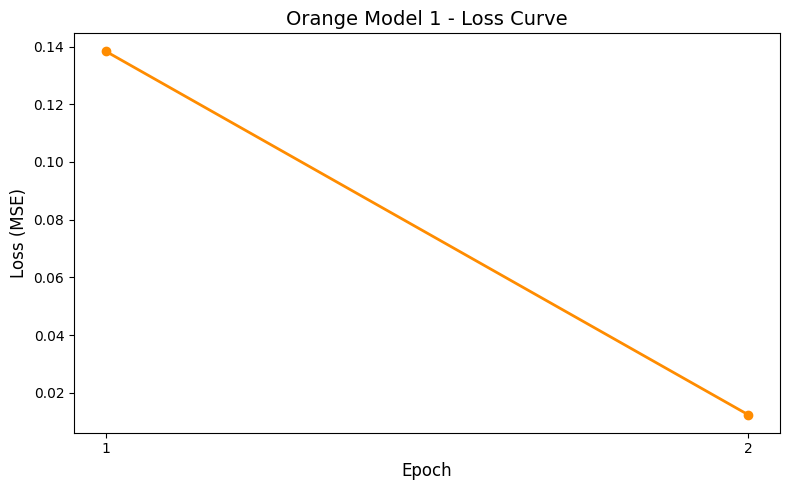

In [24]:
import matplotlib.pyplot as plt

# Loss values from your training log
losses = [0.1382870450615883, 0.012418147847604226]
epochs = [1, 2]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', linestyle='-', color='darkorange', linewidth=2)
plt.title("Orange Model 1 - Loss Curve", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

In [25]:
# Save the model after training
model_save_path = './active_learning_output_files/orange_model_1.pth'
torch.save(orange_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./active_learning_output_files/orange_model_1.pth


In [132]:
# Load the saved model
model.load_state_dict(torch.load(model_save_path))
model.to(device)

ConvNextWithRegressionHead(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)

In [26]:
model = ConvNextWithRegressionHead.from_pretrained(
    "facebook/convnext-xlarge-224-22k", config=config, output_dim=100  
)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ConvNextWithRegressionHead were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized: ['convnext.regression_head.bias', 'convnext.regression_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ConvNextWithRegressionHead(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=1024, out_features=256, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=256, out_features=1024, bias=True)

In [69]:
def load_dataset(save_path, batch_size):
    """
    Load dataset with images, labels, and cell IDs.

    Parameters:
    - save_path: Path where the dataset is stored
    - batch_size: Batch size for DataLoader

    Returns:
    - DataLoader for the dataset
    """
    images_tensor, labels_tensor, cell_ids_tensor = torch.load(save_path)

    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor, cell_ids_tensor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print(f"Loaded dataset from {save_path}")
    return data_loader

# Load the balanced test dataset
test_data_loader = load_dataset(
    "/dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt",
    batch_size=64
)

Loaded dataset from /dss/dsshome1/0F/di93quv/balanced_testset_big_100k.pt


In [28]:
embeddings = []
labels_list = []
cell_ids_list = []  

model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        inputs, labels, cell_ids = batch  
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Convert inputs from single-channel to 3 channels
        inputs = convert_to_rgb(inputs)

        # Forward pass to get logits and pooler output
        pooler_output = model(inputs)

        # Append pooler_output, labels, and cell_ids
        embeddings.append(pooler_output.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        cell_ids_list.append(cell_ids.cpu().detach().numpy())  
        
# Convert to numpy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)
cell_ids_list = np.concatenate(cell_ids_list, axis=0) 

In [36]:
import numpy as np

# Before removing duplicates: Check if duplicates exist and the shapes
print("Before removing duplicates:")
print(f"Shape of embeddings: {embeddings.shape}")
print(f"Shape of labels_list: {labels_list.shape}")
print(f"Shape of cell_ids_list: {cell_ids_list.shape}")

# Check if there are duplicates in cell_ids_list
unique_cell_ids, counts = np.unique(cell_ids_list, return_counts=True)
duplicates = unique_cell_ids[counts > 1]
if len(duplicates) > 0:
    print(f"Found duplicates in cell_ids_list: {duplicates}")
else:
    print("No duplicates found in cell_ids_list")

# Remove duplicates: Keep the first occurrence of each unique cell_id
unique_cell_ids_set = set()
filtered_embeddings = []
filtered_labels_list = []
filtered_cell_ids_list = []

for i in range(len(cell_ids_list)):
    if cell_ids_list[i] not in unique_cell_ids_set:
        unique_cell_ids_set.add(cell_ids_list[i])
        filtered_embeddings.append(embeddings[i])
        filtered_labels_list.append(labels_list[i])
        filtered_cell_ids_list.append(cell_ids_list[i])

# Convert filtered lists back to numpy arrays
filtered_embeddings = np.array(filtered_embeddings)
filtered_labels_list = np.array(filtered_labels_list)
filtered_cell_ids_list = np.array(filtered_cell_ids_list)

# After removing duplicates: Check the shapes and verify
print("\nAfter removing duplicates:")
print(f"Shape of filtered embeddings: {filtered_embeddings.shape}")
print(f"Shape of filtered labels_list: {filtered_labels_list.shape}")
print(f"Shape of filtered cell_ids_list: {filtered_cell_ids_list.shape}")

# Check again for duplicates in the filtered cell_ids_list
unique_cell_ids_after, counts_after = np.unique(filtered_cell_ids_list, return_counts=True)
duplicates_after = unique_cell_ids_after[counts_after > 1]
if len(duplicates_after) > 0:
    print(f"Found duplicates in filtered cell_ids_list: {duplicates_after}")
else:
    print("No duplicates found in filtered cell_ids_list")

Before removing duplicates:
Shape of embeddings: (110000, 100)
Shape of labels_list: (110000,)
Shape of cell_ids_list: (110000,)
Found duplicates in cell_ids_list: [     0      1      2 ... 501331 502417 503321]

After removing duplicates:
Shape of filtered embeddings: (106433, 100)
Shape of filtered labels_list: (106433,)
Shape of filtered cell_ids_list: (106433,)
No duplicates found in filtered cell_ids_list


In [37]:
import pickle
import os

# Define the save path
save_path = "./active_learning_output_files/"
file_name = "active_learning_orange_model_1.pkl"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Save embeddings, labels, and cell_ids using pickle
with open(os.path.join(save_path, file_name), 'wb') as f:
    pickle.dump({'embeddings': filtered_embeddings, 'labels': filtered_labels_list, 'cell_ids': filtered_cell_ids_list}, f)

print(f"Saved embeddings, labels, and cell_ids to {os.path.join(save_path, file_name)}")

Saved embeddings, labels, and cell_ids to ./active_learning_output_files/active_learning_orange_model_1.pkl


In [139]:
import pickle
import os

# Define the save path and file name
save_path = "./active_learning_output_files/"
file_name = "active_learning_orange_model_1.pkl"
file_path = os.path.join(save_path, file_name)

# Load the data
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract embeddings, labels, and cell_ids
embeddings = data['embeddings']
labels_list = data['labels']
cell_ids_list = data['cell_ids']

print(f"Loaded embeddings shape: {embeddings.shape}")
print(f"Loaded labels shape: {labels_list.shape}")
print(f"Loaded cell_ids shape: {cell_ids_list.shape}")

Loaded embeddings shape: (106433, 100)
Loaded labels shape: (106433,)
Loaded cell_ids shape: (106433,)


In [71]:
# Flatten the embeddings to shape [samples, features]
embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)

#UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_result = umap_reducer.fit_transform(embeddings_flat)

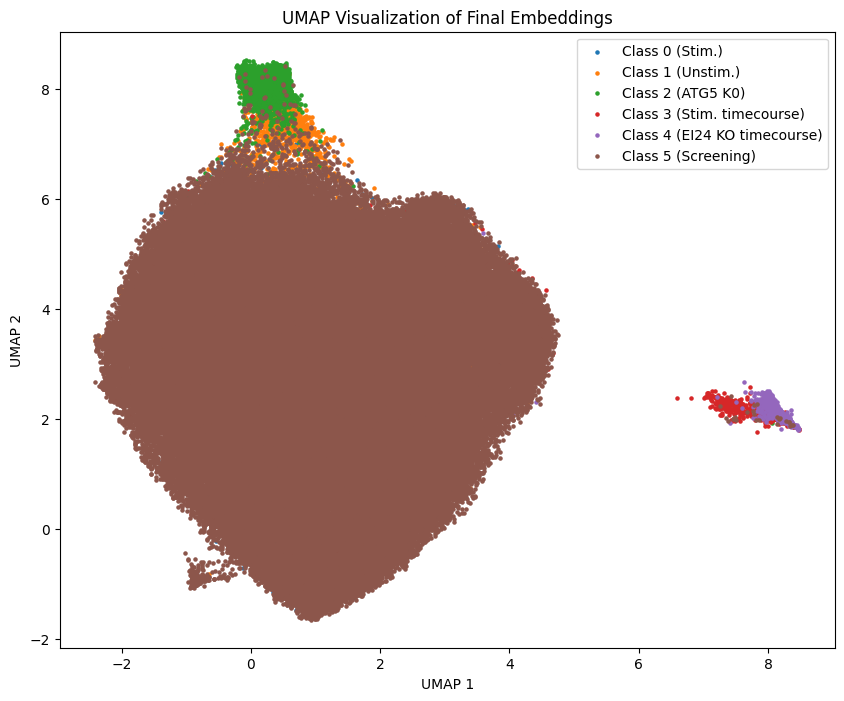

In [72]:
# Define new class labels 
class_labels = ["Class 0 (Stim.)", "Class 1 (Unstim.)", "Class 2 (ATG5 K0)", "Class 3 (Stim. timecourse)", "Class 4 (EI24 KO timecourse)", "Class 5 (Screening)"]

# Visualize UMAP
plt.figure(figsize=(10, 8))

for i, label in enumerate(class_labels):
    # Select indices for each class
    idx = labels_list == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.legend()
plt.title('UMAP Visualization of Final Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [73]:
# Parameters for kNN and Outlier Detection
k = 10  # number of nearest neighbors
n = 5000  # number of outliers to find

# Extract the UMAP result and labels
x_coords = np.asarray(umap_result[:, 0])
y_coords = np.asarray(umap_result[:, 1])
labels = np.asarray(labels_list)
cell_ids_array = np.asarray(cell_ids_list, dtype=str)

# Identify screening cells (Class 5)
screening_idx = labels == 5
screening_coords = np.column_stack((x_coords[screening_idx], y_coords[screening_idx]))

# Find the dense cluster of screening cells (non-hit control) using kNN
nbrs = NearestNeighbors(n_neighbors=k).fit(screening_coords)
distances, _ = nbrs.kneighbors(screening_coords)

# Compute the mean distance to k nearest neighbors for each cell
avg_knn_dist = distances.mean(axis=1)

# Identify the top n outliers with the biggest kNN distances
outlier_indices = np.argsort(avg_knn_dist)[-n:]

# Get the cell IDs of the outliers
outlier_cell_ids = cell_ids_array[screening_idx][outlier_indices] 

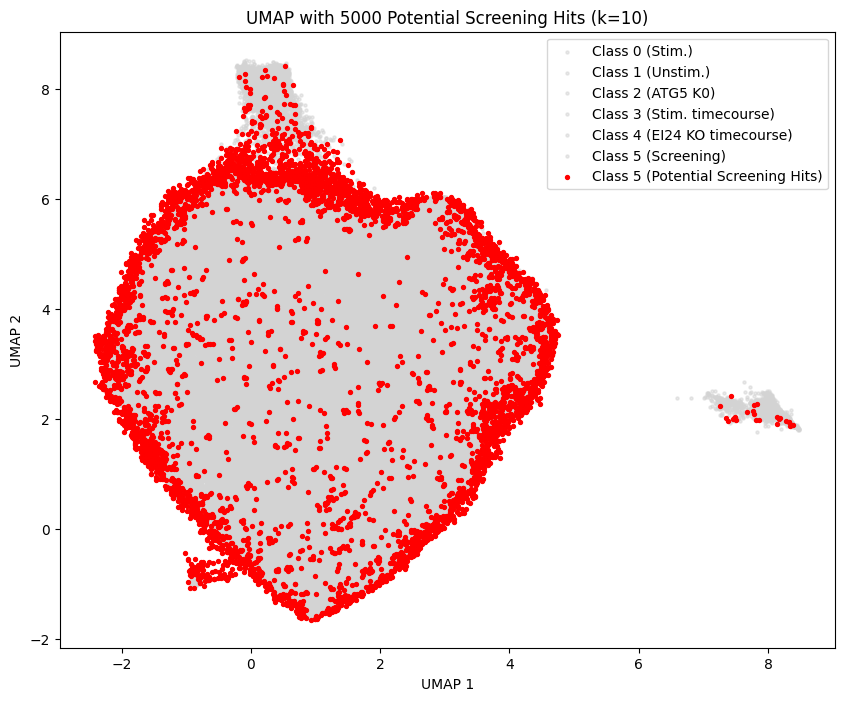

In [74]:
# Plot UMAP
plt.figure(figsize=(10, 8))

# Plot all classes (including screening) in light grey
for i, label in enumerate(class_labels):  
    idx = labels == i
    plt.scatter(x_coords[idx], y_coords[idx], color='lightgrey', label=label, s=5, alpha=0.5)

# Plot Screening cells that are identified as potential hits using kNN in red
plt.scatter(screening_coords[outlier_indices, 0], screening_coords[outlier_indices, 1], 
            color='red', label="Class 5 (Potential Screening Hits)", s=8, edgecolors='red')
plt.legend()
plt.title(f"UMAP with {n} Potential Screening Hits (k={k})")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(False)
plt.show()

In [75]:
# Save outlier cell IDs to a file
save_path = "./active_learning_output_files/orange_model_1_knn_screening_hits_old_LRZ.txt"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.savetxt(save_path, outlier_cell_ids, fmt="%s")
print(f"Saved {len(outlier_cell_ids)} potential screening hits to {save_path}")

Saved 5000 potential screening hits to ./active_learning_output_files/orange_model_1_knn_screening_hits_old_LRZ.txt


In [76]:
import pandas as pd
df = pd.read_csv("active_learning_autophagy21_classification_scores.csv")
df["Cell ID"] = df["Cell ID"].astype(str)  # Ensure Cell IDs are strings
df

,Cell ID,Autophagy On Score,Autophagy Off Score
0,409600,9.999976e-01,2.378960e-06
1,271446,9.999991e-01,9.431373e-07
2,371676,9.999878e-01,1.218928e-05
3,340348,9.999900e-01,1.002097e-05
4,31904,9.999991e-01,9.632774e-07
...,...,...,...
109995,85724,9.982374e-01,1.762557e-03
109996,121680,9.999870e-01,1.297279e-05
109997,433650,9.777784e-08,9.999999e-01
109998,355281,9.999907e-01,9.312190e-06


In [77]:
# Step 1: Convert to string for consistency
df["Cell ID"] = df["Cell ID"].astype(str)
cell_ids_str_list = list(map(str, cell_ids_list))

# Step 2: Ensure all cell IDs exist in df
df_unique = df.drop_duplicates(subset="Cell ID").copy()
existing_ids = set(df_unique["Cell ID"])
valid_cell_ids = [cid for cid in cell_ids_str_list if cid in existing_ids]

print(f"Original list length: {len(cell_ids_str_list)}")
print(f"Valid unique IDs found in df: {len(valid_cell_ids)}")
print(f"Shape of df_unique: {df_unique.shape}")

# Step 3: Subset in order
df_indexed = df_unique.set_index("Cell ID")
filtered_df_ordered = df_indexed.loc[valid_cell_ids].reset_index()

# Step 4: Sanity check
ordered_match = np.all(filtered_df_ordered['Cell ID'].values == np.array(valid_cell_ids))
print(f"Final filtered shape: {filtered_df_ordered.shape}")
print(f"Order matches cell_ids_list? {ordered_match}")

Original list length: 106433
Valid unique IDs found in df: 106433
Shape of df_unique: (106433, 3)
Final filtered shape: (106433, 3)
Order matches cell_ids_list? True


In [78]:
# Your class label names
class_labels = [
    "Class 0 (Stim.)", 
    "Class 1 (Unstim.)", 
    "Class 2 (ATG5 K0)", 
    "Class 3 (Stim. timecourse)", 
    "Class 4 (EI24 KO timecourse)", 
    "Class 5 (Screening)"
]

# Add numeric class label (assuming labels_list is ordered to match)
filtered_df_ordered["class_label"] = labels_list

# Add readable class label using mapping
filtered_df_ordered["class_label_name"] = [class_labels[i] for i in labels_list]
filtered_df_ordered

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name
0,93304,9.999999e-01,1.641715e-07,5,Class 5 (Screening)
1,403605,9.999995e-01,4.513647e-07,5,Class 5 (Screening)
2,148320,9.999951e-01,4.839426e-06,5,Class 5 (Screening)
3,499836,9.946819e-01,5.318082e-03,5,Class 5 (Screening)
4,448940,8.273506e-01,1.726494e-01,5,Class 5 (Screening)
...,...,...,...,...,...
106428,49484,9.999998e-01,2.555670e-07,5,Class 5 (Screening)
106429,207645,9.999995e-01,5.326859e-07,5,Class 5 (Screening)
106430,580728,5.105115e-07,9.999995e-01,2,Class 2 (ATG5 K0)
106431,333945,9.999932e-01,6.805804e-06,5,Class 5 (Screening)


In [79]:
count_df = filtered_df_ordered["class_label_name"].value_counts().reset_index()
count_df.columns = ["Class Label", "Cell Count"]
count_df

,Class Label,Cell Count
0,Class 5 (Screening),99287
1,Class 2 (ATG5 K0),1831
2,Class 1 (Unstim.),1807
3,Class 0 (Stim.),1789
4,Class 3 (Stim. timecourse),959
5,Class 4 (EI24 KO timecourse),760


In [80]:
# Check if 'Cell ID' has duplicates in df
cell_id_duplicates = df["Cell ID"].duplicated(keep=False)  # Marks all duplicates as True
duplicated_cell_ids = df[cell_id_duplicates]

# Print out duplicated cell IDs (if any)
print(duplicated_cell_ids)

       Cell ID  Autophagy On Score  Autophagy Off Score
44         476        1.436394e-03             0.998564
45      420700        1.073452e-07             1.000000
75         615        2.970107e-02             0.970299
81      217412        9.925733e-01             0.007427
107        483        9.978655e-01             0.002134
...        ...                 ...                  ...
109763    1087        1.045374e-02             0.989546
109787     894        6.431243e-05             0.999936
109814      72        6.509799e-01             0.349020
109850    1451        1.631395e-01             0.836861
109899     481        7.765298e-04             0.999224

[5898 rows x 3 columns]


In [81]:
# Step 1: Define the binning function based on Autophagy Off Score
def assign_bin(score):
    if score > 0.99999:
        return "bin 1 screening"
    elif score > 0.999:
        return "bin 2 screening"
    elif score > 0.9975:
        return "bin 3 screening"
    elif score > 0.995:
        return "bin 4 screening"
    elif score > 0.99:
        return "bin 5 screening"
    elif score > 0.98:
        return "bin 6 screening"
    else:
        return "not excised screening"

# Step 2: Apply the binning function for Class 5, and "other classes" elsewhere
filtered_df_ordered["screening_bin"] = filtered_df_ordered.apply(
    lambda row: assign_bin(row["Autophagy Off Score"]) if row["class_label"] == 5 else "other classes",
    axis=1
)

filtered_df_ordered

,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin
0,93304,9.999999e-01,1.641715e-07,5,Class 5 (Screening),not excised screening
1,403605,9.999995e-01,4.513647e-07,5,Class 5 (Screening),not excised screening
2,148320,9.999951e-01,4.839426e-06,5,Class 5 (Screening),not excised screening
3,499836,9.946819e-01,5.318082e-03,5,Class 5 (Screening),not excised screening
4,448940,8.273506e-01,1.726494e-01,5,Class 5 (Screening),not excised screening
...,...,...,...,...,...,...
106428,49484,9.999998e-01,2.555670e-07,5,Class 5 (Screening),not excised screening
106429,207645,9.999995e-01,5.326859e-07,5,Class 5 (Screening),not excised screening
106430,580728,5.105115e-07,9.999995e-01,2,Class 2 (ATG5 K0),other classes
106431,333945,9.999932e-01,6.805804e-06,5,Class 5 (Screening),not excised screening


In [82]:
# Count the number of instances in each bin
bin_counts = filtered_df_ordered["screening_bin"].value_counts().sort_index()

# Display the counts
print(bin_counts)

bin 1 screening            143
bin 2 screening            483
bin 3 screening            161
bin 4 screening            108
bin 5 screening            120
bin 6 screening            116
not excised screening    98156
other classes             7146
Name: screening_bin, dtype: int64


In [83]:
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

%matplotlib inline

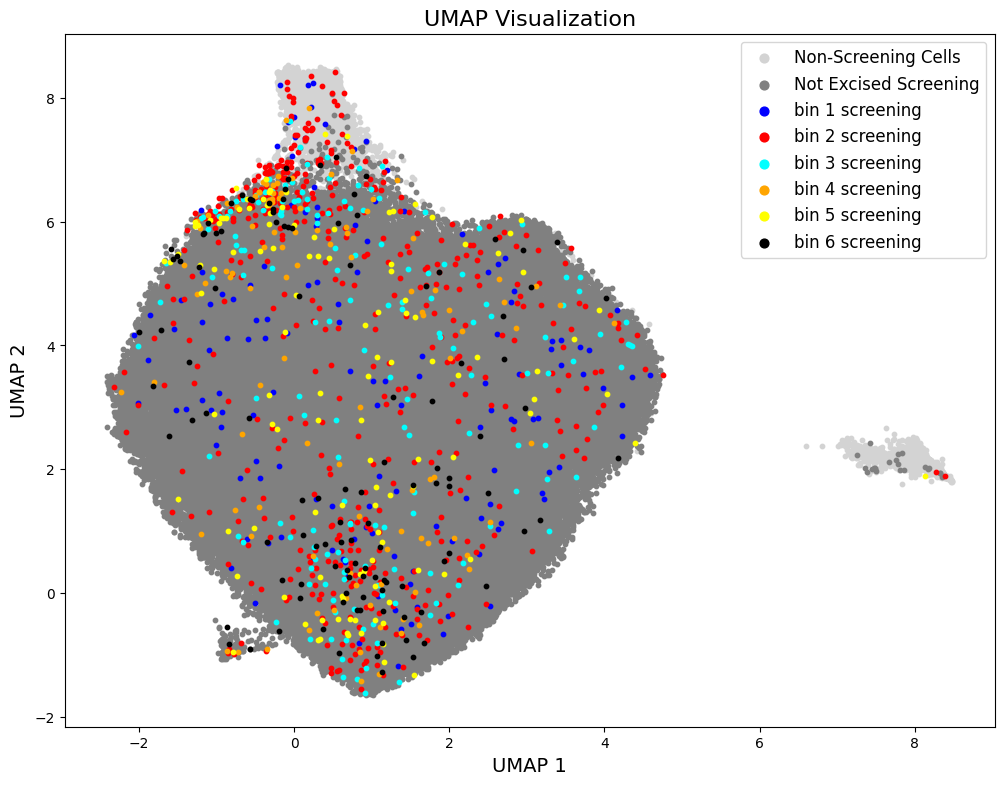

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define the bin colors as you have them
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

# Increase the figure size for a larger plot
plt.figure(figsize=(12, 9))

# Step 1: First, plot all non-screening cells in lightgrey
non_screening_mask = filtered_df_ordered["class_label"] != 5
plt.scatter(umap_result[non_screening_mask, 0], umap_result[non_screening_mask, 1], 
            color='lightgrey', label='Non-Screening Cells', s=10)

# Step 2: Plot all screening cells with "not excised screening" in light green
not_excised_mask = (filtered_df_ordered["class_label"] == 5) & (filtered_df_ordered["screening_bin"] == "not excised screening")
plt.scatter(umap_result[not_excised_mask, 0], umap_result[not_excised_mask, 1], 
            color='grey', label='Not Excised Screening', s=10)

# Step 3: Plot screening bins with their respective colors
for bin_label, color in bin_colors.items():
    if bin_label != "not excised screening" and bin_label != "other classes":
        bin_mask = (filtered_df_ordered["screening_bin"] == bin_label)
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1], 
                    color=color, label=bin_label, s=10)

# Add labels, title, and legend
plt.title('UMAP Visualization', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

# Adjust the legend, increase markerscale for larger dots
plt.legend(loc='best', fontsize=12, markerscale=2)


# Show the plot
plt.show()

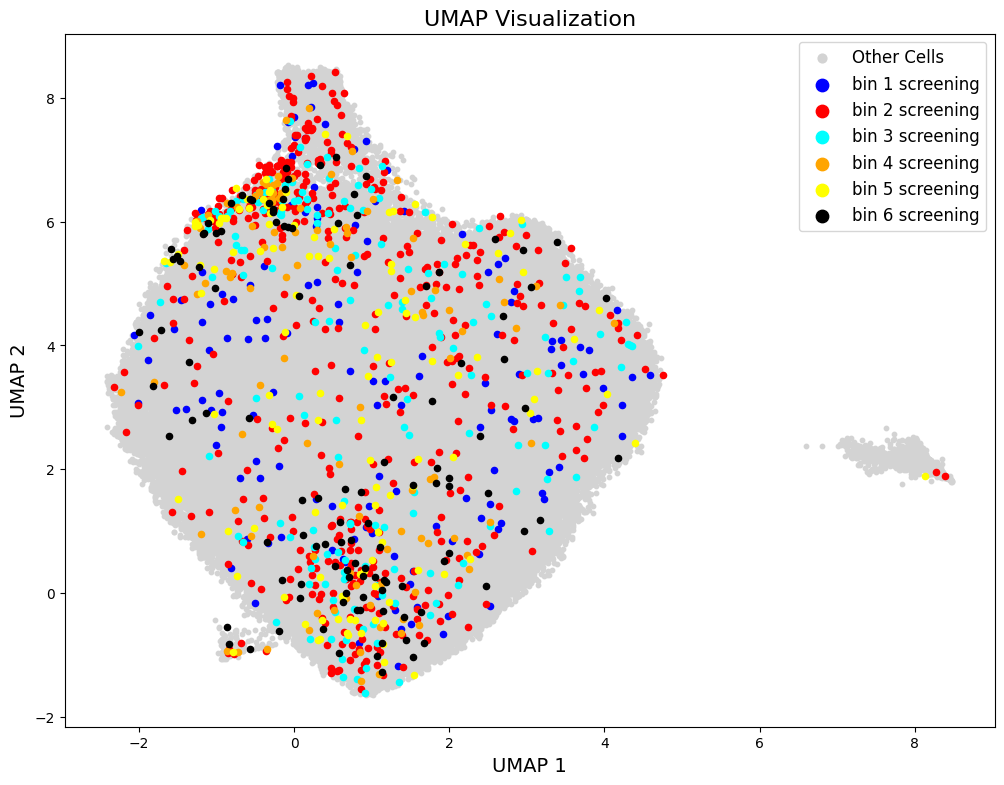

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define the bin colors as you have them
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

# Increase the figure size for a larger plot
plt.figure(figsize=(12, 9))

# Step 1: Plot all cells in light grey first (non-relevant ones will be grey)
plt.scatter(umap_result[:, 0], umap_result[:, 1], 
            color='lightgrey', s=10, label='Other Cells')

# Step 2: Plot screening bins with their respective colors (only relevant cells)
for bin_label, color in bin_colors.items():
    if bin_label != "not excised screening" and bin_label != "other classes":
        bin_mask = filtered_df_ordered["screening_bin"] == bin_label
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1], 
                    color=color, label=bin_label, s=20)  # Slightly larger markers for bins

# Add labels, title, and legend
plt.title('UMAP Visualization', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

# Adjust the legend, increase markerscale for larger dots
plt.legend(loc='best', fontsize=12, markerscale=2)

# Show the plot
plt.show()

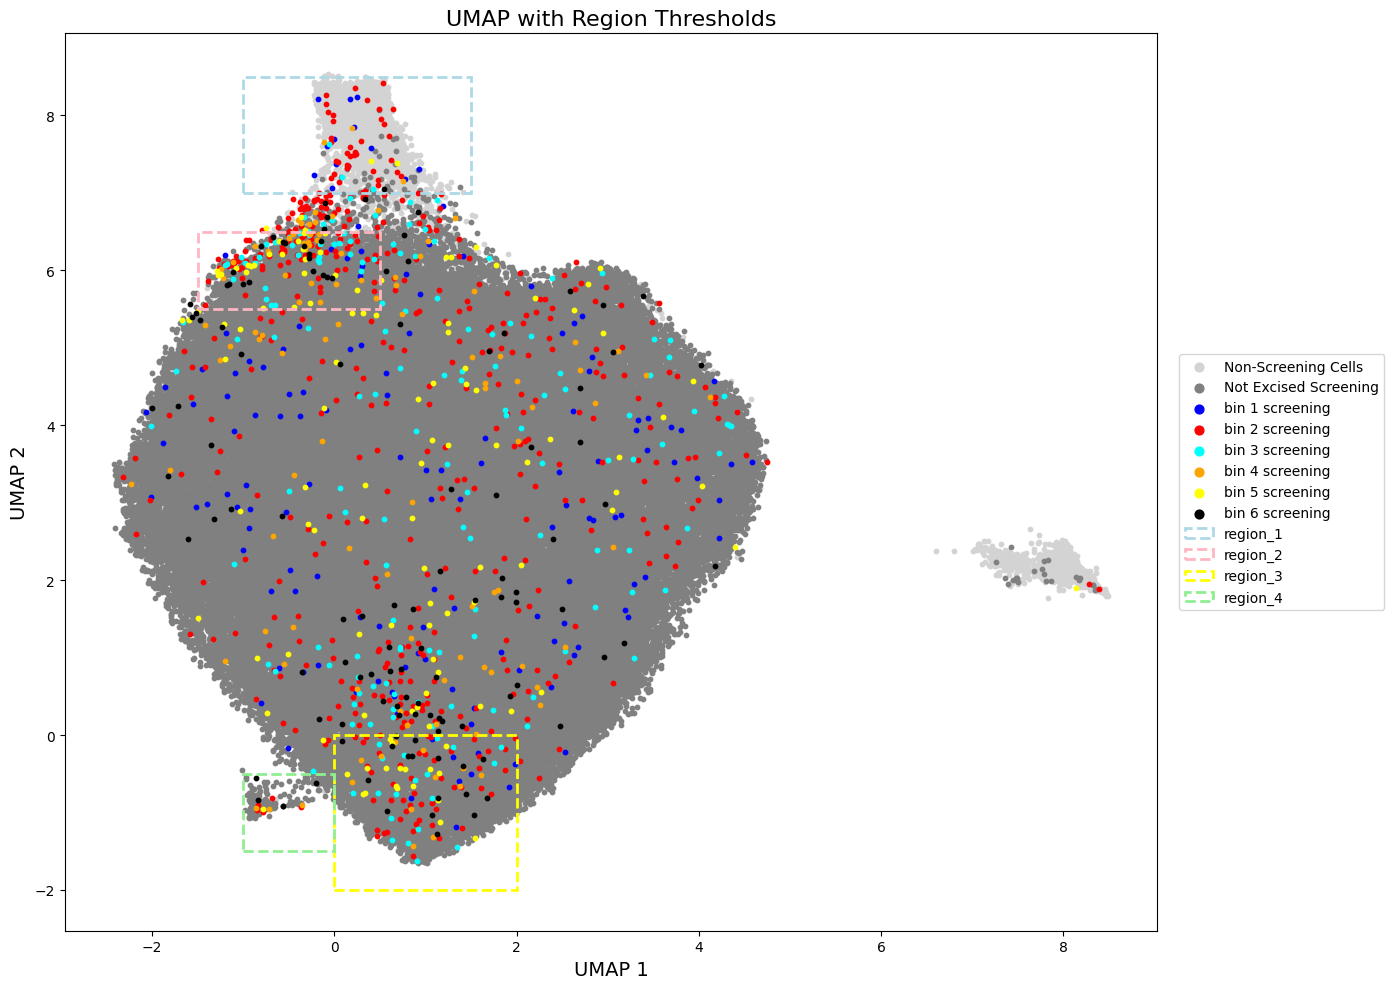

In [133]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Redefine the regions with different edge colors
regions = [
    {"name": "region_1", "x": (-1, 1.5), "y": (7, 8.5), "edgecolor": 'lightblue'},
    {"name": "region_2", "x": (-1.5, 0.5), "y": (5.5, 6.5), "edgecolor": 'lightpink'},
    {"name": "region_3", "x": (0, 2), "y": (-2, 0), "edgecolor": 'yellow'},
    {"name": "region_4", "x": (-1, 0), "y": (-1.5, -0.5), "edgecolor": 'lightgreen'},
]

# Plot base UMAP with same coloring as before
plt.figure(figsize=(14, 10))

# Plot non-screening cells
non_screening_mask = filtered_df_ordered["class_label"] != 5
plt.scatter(umap_result[non_screening_mask, 0], umap_result[non_screening_mask, 1],
            color='lightgrey', label='Non-Screening Cells', s=10)

# Plot not-excised screening
not_excised_mask = (filtered_df_ordered["class_label"] == 5) & \
                   (filtered_df_ordered["screening_bin"] == "not excised screening")
plt.scatter(umap_result[not_excised_mask, 0], umap_result[not_excised_mask, 1],
            color='grey', label='Not Excised Screening', s=10)

# Plot excised bins
for bin_label, color in bin_colors.items():
    if bin_label not in ["not excised screening", "other classes"]:
        bin_mask = (filtered_df_ordered["screening_bin"] == bin_label)
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1],
                    color=color, label=bin_label, s=10)

# Add threshold rectangles with varying edge colors (no fill)
for region in regions:
    x0, x1 = region["x"]
    y0, y1 = region["y"]
    width = x1 - x0
    height = y1 - y0
    rect = Rectangle((x0, y0), width, height,
                     linewidth=2, edgecolor=region["edgecolor"], facecolor='none', linestyle='--', label=region["name"])
    plt.gca().add_patch(rect)

# Labels and legend
plt.title('UMAP with Region Thresholds', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, markerscale=2, borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for legend

plt.tight_layout()
plt.show()

In [126]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd

# ---- Define regions ---- #
regions = [
    {"name": "region_1", "x": (-1, 1.5), "y": (7, 8.5)},
    {"name": "region_2", "x": (-1.5, 0.5), "y": (5.5, 6.5)},
    {"name": "region_3", "x": (0, 2), "y": (-2, 0)},
    {"name": "region_4", "x": (-1, 0), "y": (-1.5, -0.5)},
]

# ---- Helper to get cell IDs in region ---- #
def get_cell_ids_from_region(region, df, umap_result, n=3):
    x0, x1 = region["x"]
    y0, y1 = region["y"]
    x_coords = umap_result[:, 0]
    y_coords = umap_result[:, 1]

    mask = (x_coords >= x0) & (x_coords <= x1) & \
           (y_coords >= y0) & (y_coords <= y1)
    region_df = df[mask]

    cell_ids = region_df["Cell ID"].astype(str).unique()[:n]
    return list(cell_ids)

In [127]:
# ---- Get 3 cell IDs from each region ---- #
region_to_cells = []
for region in regions:
    cell_ids = get_cell_ids_from_region(region, filtered_df_ordered, umap_result, n=3)
    region_to_cells.extend([(region["name"], cid) for cid in cell_ids])

In [128]:
# ---- Visualize cell images ---- #
def visualize_cells_with_region_labels(region_cell_tuples, data_loader):
    import matplotlib.pyplot as plt

    target_ids = set(cid for _, cid in region_cell_tuples)
    images_to_plot = {}

    for images, labels, cell_ids in data_loader:
        for i in range(len(cell_ids)):
            cid = str(cell_ids[i].item())
            if cid in target_ids:
                img = images[i].cpu().numpy()
                images_to_plot[cid] = img
        if len(images_to_plot) >= len(target_ids):
            break

    # Plot
    cols = 3
    rows = int(np.ceil(len(region_cell_tuples) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = np.array(axes).reshape(-1)

    for ax, (region, cid) in zip(axes, region_cell_tuples):
        img_data = images_to_plot.get(cid)
        if img_data is None:
            ax.axis("off")
            continue
        if img_data.shape[0] == 1:
            ax.imshow(img_data[0], cmap="viridis")
        else:
            ax.imshow(np.moveaxis(img_data, 0, -1))  # (C,H,W) → (H,W,C)
        ax.set_title(f"{region}\nCell ID: {cid}", fontsize=9)
        ax.axis("off")

    for ax in axes[len(region_cell_tuples):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

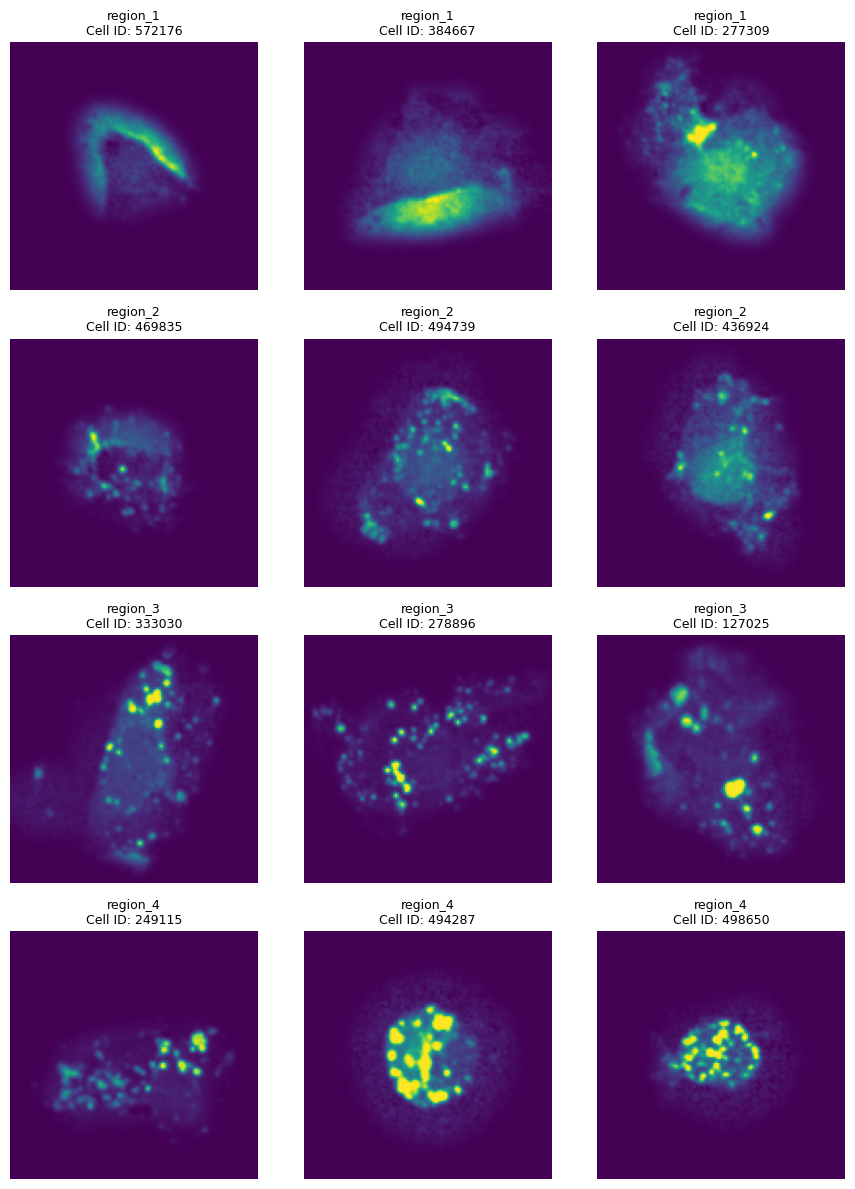

In [130]:
# ---- Call the image visualizer ---- #
visualize_cells_with_region_labels(region_to_cells, test_data_loader)

In [87]:
# Load the list of CSH cells from the text file
with open('./active_learning_output_files/orange_model_1_knn_screening_hits_old_LRZ.txt') as f:
    csh_cells = set(line.strip() for line in f.readlines())

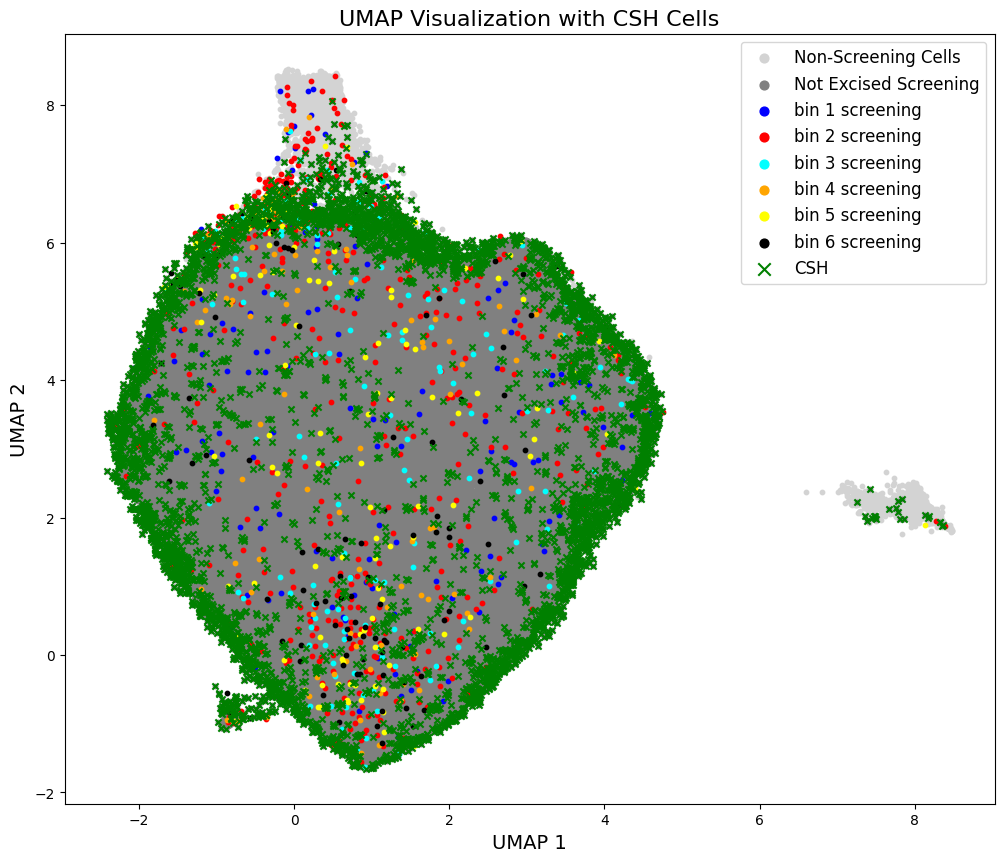

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define the bin colors as you have them
bin_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black",
    "not excised screening": "grey",
    "other classes": "lightgrey"
}

# Increase the figure size for a larger plot
plt.figure(figsize=(12, 10))

# Step 1: First, plot all non-screening cells in lightgrey
non_screening_mask = filtered_df_ordered["class_label"] != 5
plt.scatter(umap_result[non_screening_mask, 0], umap_result[non_screening_mask, 1], 
            color='lightgrey', label='Non-Screening Cells', s=10)

# Step 2: Plot all screening cells with "not excised screening" in light green
not_excised_mask = (filtered_df_ordered["class_label"] == 5) & (filtered_df_ordered["screening_bin"] == "not excised screening")
plt.scatter(umap_result[not_excised_mask, 0], umap_result[not_excised_mask, 1], 
            color='grey', label='Not Excised Screening', s=10)

# Step 3: Plot screening bins with their respective colors
for bin_label, color in bin_colors.items():
    if bin_label != "not excised screening" and bin_label != "other classes":
        bin_mask = (filtered_df_ordered["screening_bin"] == bin_label)
        plt.scatter(umap_result[bin_mask, 0], umap_result[bin_mask, 1], 
                    color=color, label=bin_label, s=10)

# Step 4: Find CSH cells within "not excised screening" and plot them with an "x" marker in green
csh_mask = (filtered_df_ordered["class_label"] == 5) & (filtered_df_ordered["screening_bin"] == "not excised screening") & \
           (filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells))
plt.scatter(umap_result[csh_mask, 0], umap_result[csh_mask, 1], 
            color='green', marker='x', label='CSH', s=20)  # "x" marker with larger size for visibility

# Add labels, title, and legend
plt.title('UMAP Visualization with CSH Cells', fontsize=16)
plt.xlabel('UMAP 1', fontsize=14)
plt.ylabel('UMAP 2', fontsize=14)

# Adjust the legend, increase markerscale for larger dots
plt.legend(loc='best', fontsize=12, markerscale=2)

# Show the plot
plt.show()

Total number of filtered_df entries: 106433

Cell Counts per Bin:
not excised screening    98156
other classes             7146
bin 2 screening            483
bin 3 screening            161
bin 1 screening            143
bin 5 screening            120
bin 6 screening            116
bin 4 screening            108
Name: screening_bin, dtype: int64

Cell Percentages per Bin:
not excised screening    92.223277
other classes             6.714083
bin 2 screening           0.453807
bin 3 screening           0.151269
bin 1 screening           0.134357
bin 5 screening           0.112747
bin 6 screening           0.108989
bin 4 screening           0.101472
Name: screening_bin, dtype: float64


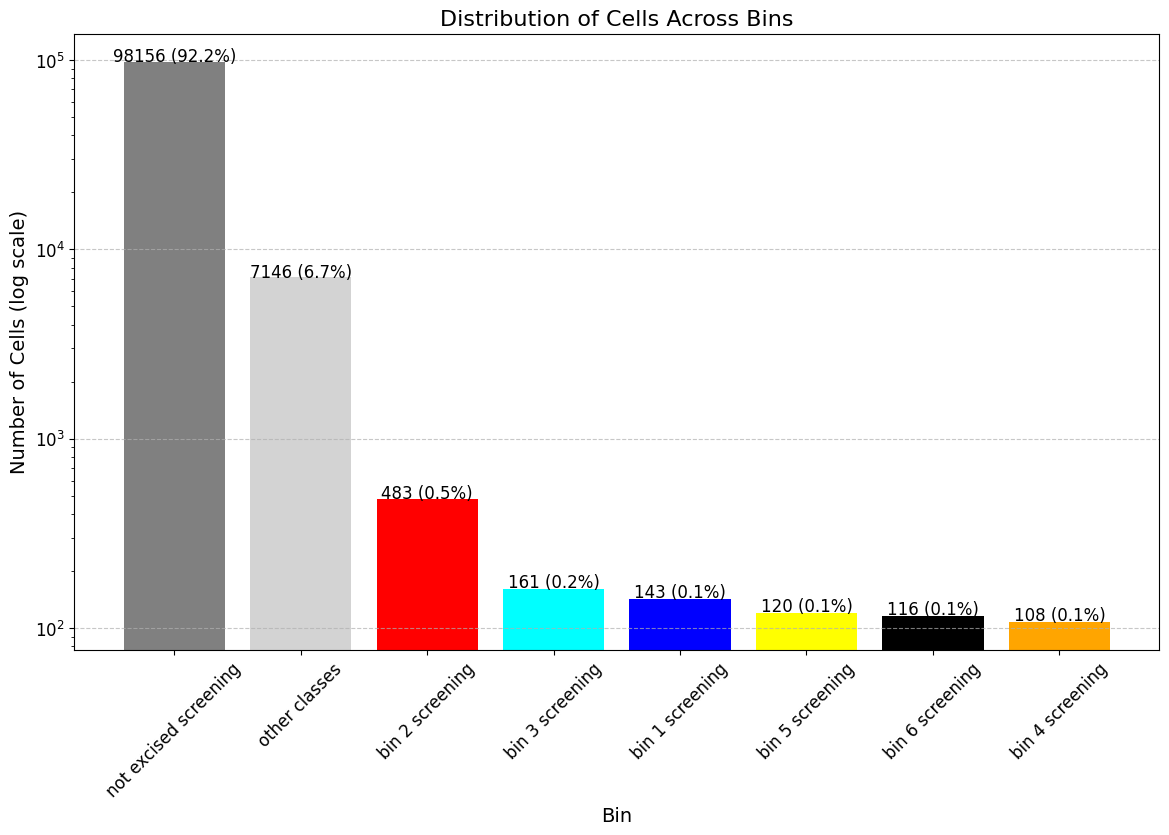

In [91]:
import matplotlib.pyplot as plt

# Step 1: Count occurrences of each bin
bin_counts = filtered_df_ordered["screening_bin"].value_counts()

# Step 2: Compute percentages
total_cells = len(filtered_df_ordered)
bin_percentages = (bin_counts / total_cells) * 100

# Step 3: Print results
print(f"Total number of filtered_df entries: {total_cells}\n")
print("Cell Counts per Bin:")
print(bin_counts)
print("\nCell Percentages per Bin:")
print(bin_percentages)

# Step 4: Create stacked bar plot
plt.figure(figsize=(14, 8))

# Step 5: Plot the stacked bar chart with bin colors
bars = plt.bar(bin_counts.index, bin_counts.values, 
               color=[bin_colors.get(bin, 'lightgrey') for bin in bin_counts.index])

# Step 6: Add labels on top of bars (count + percentage)
for bar, count, percentage in zip(bars, bin_counts.values, bin_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f"{count} ({percentage:.1f}%)", 
             ha="center", fontsize=12)

# Step 7: Formatting
plt.xlabel("Bin", fontsize=14)
plt.ylabel("Number of Cells (log scale)", fontsize=14)
plt.title("Distribution of Cells Across Bins", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Set Y-axis to log scale
plt.yscale("log")

# Step 8: Save the plot (optional)
# output_path = "./active_learning_output_files/bin_distribution.png"
# plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show plot
plt.show()

In [92]:
# Step 0: Load CSH cell list
with open('./active_learning_output_files/blue_model_knn_screening_hits_old_LRZ_testset.txt') as f:
    csh_cells = set(line.strip() for line in f.readlines()) # not just csh cells but all kNN 5000 cells!!!

    
excised_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening", 
                "bin 4 screening", "bin 5 screening", "bin 6 screening"]

# Step 1: Count how many CSH cells fall into each excised bin
csh_excised_bin_counts = filtered_df_ordered[
    filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells) &
    filtered_df_ordered["screening_bin"].isin(excised_bins)
]["screening_bin"].value_counts()

# Step 2: Count "CSH" in not-excised bin as before
csh_not_excised_count = filtered_df_ordered[
    (filtered_df_ordered["class_label"] == 5) &
    (filtered_df_ordered["screening_bin"] == "not excised screening") &
    (filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells))
].shape[0]

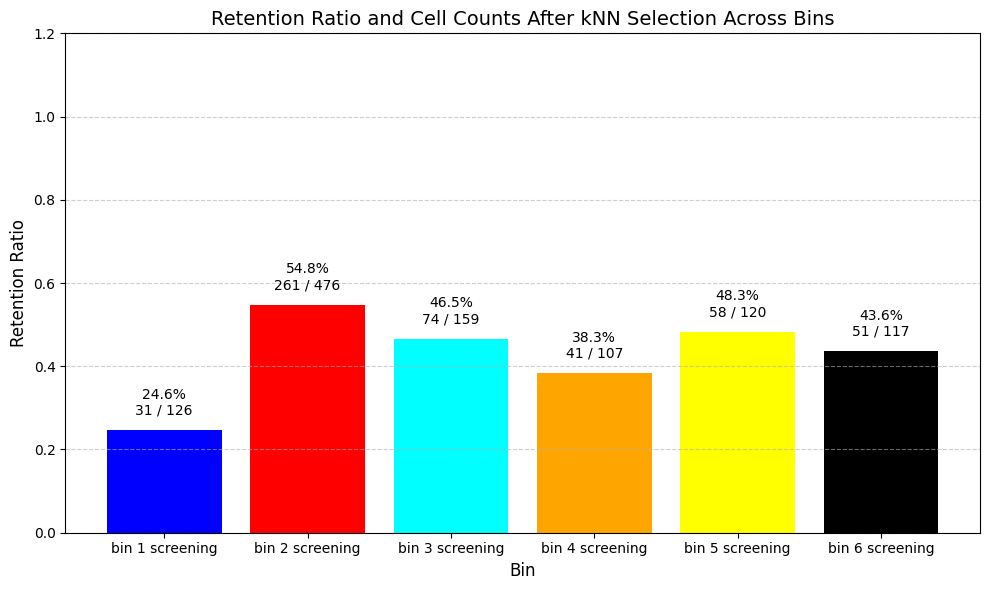

In [94]:
target_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening", 
               "bin 4 screening", "bin 5 screening", "bin 6 screening"]

plot_colors = {
    "bin 1 screening": "blue",
    "bin 2 screening": "red",
    "bin 3 screening": "cyan",
    "bin 4 screening": "orange",
    "bin 5 screening": "yellow",
    "bin 6 screening": "black"
}

import matplotlib.pyplot as plt

# Step 1: Your original and after-kNN counts
original_counts = {
    "bin 1 screening": 126,
    "bin 2 screening": 476,
    "bin 3 screening": 159,
    "bin 4 screening": 107,
    "bin 5 screening": 120,
    "bin 6 screening": 117
}

after_knn_counts = {
    "bin 1 screening": csh_excised_bin_counts.get("bin 1 screening", 0),
    "bin 2 screening": csh_excised_bin_counts.get("bin 2 screening", 0),
    "bin 3 screening": csh_excised_bin_counts.get("bin 3 screening", 0),
    "bin 4 screening": csh_excised_bin_counts.get("bin 4 screening", 0),
    "bin 5 screening": csh_excised_bin_counts.get("bin 5 screening", 0),
    "bin 6 screening": csh_excised_bin_counts.get("bin 6 screening", 0)
}

bins = list(original_counts.keys())
ratios = [after_knn_counts[b] / original_counts[b] if original_counts[b] > 0 else 0 for b in bins]

# Step 2: Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(bins, ratios, color=[plot_colors.get(b, 'gray') for b in bins])

# Step 3: Add labels: ratio + raw counts
for bar, bin_label in zip(bars, bins):
    after = after_knn_counts[bin_label]
    before = original_counts[bin_label]
    ratio = after / before if before > 0 else 0

    label_text = f"{ratio * 100:.1f}%\n{after} / {before}"

    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.03,
        label_text,
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 4: Final touches
plt.title("Retention Ratio and Cell Counts After kNN Selection Across Bins", fontsize=14)
plt.xlabel("Bin", fontsize=12)
plt.ylabel("Retention Ratio", fontsize=12)
plt.ylim(0, 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [95]:
filtered_df_ordered["class_label_name"].value_counts()

Class 5 (Screening)             99287
Class 2 (ATG5 K0)                1831
Class 1 (Unstim.)                1807
Class 0 (Stim.)                  1789
Class 3 (Stim. timecourse)        959
Class 4 (EI24 KO timecourse)      760
Name: class_label_name, dtype: int64

In [96]:
# Step 1: Filter the dataframe to only include rows for bins 1-6
valid_bins = ['bin 1 screening', 'bin 2 screening', 'bin 3 screening', 'bin 4 screening', 'bin 5 screening', 'bin 6 screening']
filtered_bins_df = filtered_df_ordered[filtered_df_ordered["screening_bin"].isin(valid_bins)]

# Step 2: Count occurrences of each bin (bins 1-6)
bin_counts = filtered_bins_df["screening_bin"].value_counts()

# Step 3: Compute the total number of cells in the filtered dataframe (only bins 1-6)
total_cells_in_bins = bin_counts.sum()  # Sum of the counts for bins 1-6

# Step 4: Compute percentages for each bin
total_cells = len(filtered_bins_df)  # Total number of valid cells in bins 1-6
bin_percentages = (bin_counts / total_cells) * 100

# Step 5: Combine counts and percentages into a single dataframe for easy display
bin_summary = pd.DataFrame({
    'Cell Count': bin_counts,
    'Percentage (%)': bin_percentages
})

# Step 6: Print results
print(f"Total number of filtered cells in bins 1-6: {total_cells_in_bins}\n")
print("Cell Counts and Percentages per Bin:")
print(bin_summary)

Total number of filtered cells in bins 1-6: 1131

Cell Counts and Percentages per Bin:
                 Cell Count  Percentage (%)
bin 2 screening         483       42.705570
bin 3 screening         161       14.235190
bin 1 screening         143       12.643678
bin 5 screening         120       10.610080
bin 6 screening         116       10.256410
bin 4 screening         108        9.549072


In [97]:
excised_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening", 
                "bin 4 screening", "bin 5 screening", "bin 6 screening"]

# Get only the CSH cells that are in excised bins
excised_df = filtered_df_ordered[
    filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells) &
    filtered_df_ordered["screening_bin"].isin(excised_bins)
].copy()

# Count these rows
print(f"Total cells in excised bins (bin 1–6): {excised_df.shape[0]}")

Total cells in excised bins (bin 1–6): 516


p-value: 1.0
The p-value is not significant, meaning the active learning approach is not significantly different from random.


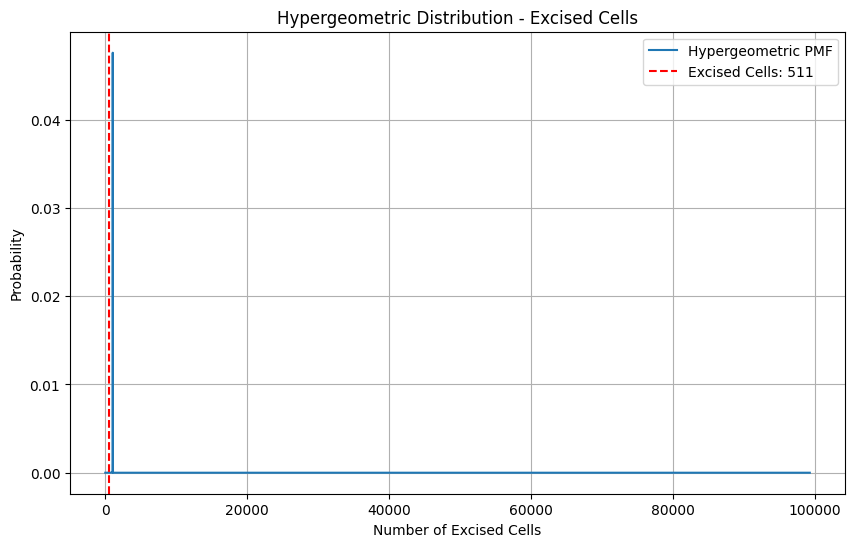

In [98]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Given values
total_cells = 106433       # Total number of cells
total_screening_cells = 99270  # Total number of screening cells
total_with_bin_info = 1131    # Total number of cells with bin information
total_excised_cells = 511    # Total number of excised cells in active learning approach

# Perform hypergeometric test
# Hypergeometric test: P(X=k) = (comb(K, k) * comb(N-K, M-k)) / comb(N, M)
# Where:
#   N = total_cells (106433)
#   M = total_screening_cells (99270)
#   K = total_with_bin_info (1105)
#   k = total_excised_cells (518)

p_value = stats.hypergeom.sf(total_excised_cells - 1, total_cells, total_with_bin_info, total_screening_cells)

# Output p-value
print(f"p-value: {p_value}")

# Determine if p-value is significant
alpha = 0.05
if p_value < alpha:
    print("The p-value is significant, meaning the active learning approach is significantly different from random.")
else:
    print("The p-value is not significant, meaning the active learning approach is not significantly different from random.")

# Now let's plot the hypergeometric distribution to visualize the distribution and the p-value
x = np.arange(0, total_screening_cells + 1)
hypergeom_pmf = stats.hypergeom.pmf(x, total_cells, total_with_bin_info, total_screening_cells)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(x, hypergeom_pmf, label="Hypergeometric PMF")
plt.axvline(total_excised_cells, color='r', linestyle='dashed', label=f'Excised Cells: {total_excised_cells}')
plt.title('Hypergeometric Distribution - Excised Cells')
plt.xlabel('Number of Excised Cells')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)

# Add a horizontal line for the significance threshold (optional)
plt.fill_between(x, 0, hypergeom_pmf, where=(x <= total_excised_cells), color='skyblue', alpha=0.5)

plt.show()

In [99]:
from scipy.stats import hypergeom

# Constants
total_cells = 106433
total_screening_cells = 99270

# Bin names you're interested in
excised_bins = ["bin 1 screening", "bin 2 screening", "bin 3 screening",
                "bin 4 screening", "bin 5 screening", "bin 6 screening"]

# Results dictionary to store p-values
bin_significance_results = []

# Loop over each bin
for bin_label in excised_bins:
    # Total cells that fall into this bin (from original dataset)
    num_in_bin = filtered_df_ordered[filtered_df_ordered["screening_bin"] == bin_label].shape[0]

    # How many of these were selected by active learning (CSH cells)
    num_csh_in_bin = excised_df[excised_df["screening_bin"] == bin_label].shape[0]

    # Hypergeometric test
    p_val = hypergeom.sf(num_csh_in_bin - 1, total_cells, num_in_bin, total_screening_cells)

    bin_significance_results.append({
        "Bin": bin_label,
        "Bin Total": num_in_bin,
        "CSH Selected": num_csh_in_bin,
        "p-value": p_val
    })

# Convert to DataFrame for nicer viewing
import pandas as pd
results_df = pd.DataFrame(bin_significance_results)
results_df["Significant (p < 0.05)"] = results_df["p-value"] < 0.05

# Print nicely
print(results_df.to_string(index=False))

            Bin  Bin Total  CSH Selected  p-value  Significant (p < 0.05)
bin 1 screening        143            31      1.0                   False
bin 2 screening        483           261      1.0                   False
bin 3 screening        161            74      1.0                   False
bin 4 screening        108            41      1.0                   False
bin 5 screening        120            58      1.0                   False
bin 6 screening        116            51      1.0                   False


In [105]:
# Save excised_df to CSV
output_path = './active_learning_output_files/Orange_model_1_excised_cells_old_LRZ.csv'
excised_df.to_csv(output_path, index=False)
print(f"Excised dataframe saved to {output_path}")

Excised dataframe saved to ./active_learning_output_files/Orange_model_1_excised_cells_old_LRZ.csv


In [106]:
# Subset filtered_df_ordered to only include CSH cells
csh_df_for_images = filtered_df_ordered[
    (filtered_df_ordered["Cell ID"].astype(str).isin(csh_cells)) &
    (filtered_df_ordered["screening_bin"] == "not excised screening")
].copy()

# Add a column for plotting consistency
csh_df_for_images["Bin"] = "CSH"

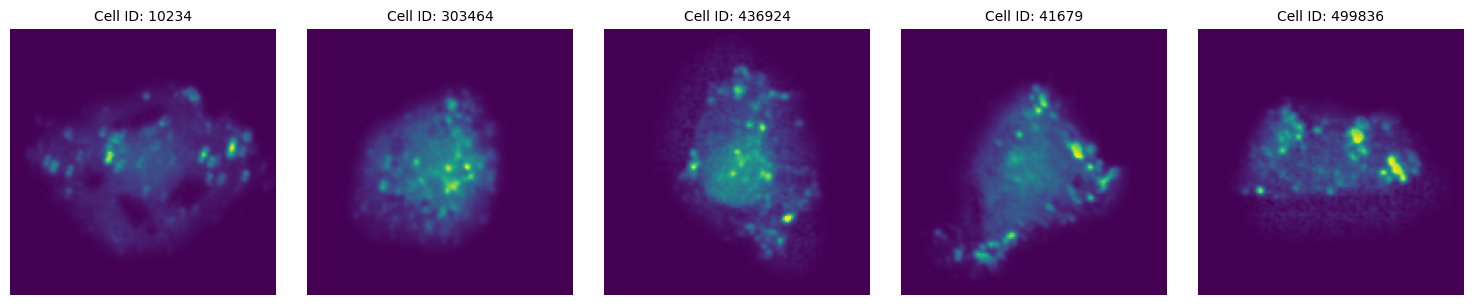

In [107]:
visualize_csh_images_from_filtered_df(
    filtered_df=csh_df_for_images,
    data_loader=test_data_loader
)

In [109]:
import pandas as pd

# Load both datasets
orange_df = pd.read_csv('./active_learning_output_files/Orange_model_1_excised_cells_old_LRZ.csv')
blue_df = pd.read_csv('./active_learning_output_files/Blue_model_excised_cells_old_LRZ.csv')


In [110]:
# Assuming the unique identifier column is named 'cell_id'
orange_cell_ids = set(orange_df['Cell ID'])
blue_cell_ids = set(blue_df['Cell ID'])

# Find Orange-exclusive cells
orange_only_ids = orange_cell_ids - blue_cell_ids

# Filter Orange dataframe to keep only those
orange_only_df = orange_df[orange_df['Cell ID'].isin(orange_only_ids)]

# Display result
print(f"Number of cells in Orange but not in Blue: {len(orange_only_df)}")
orange_only_df.head()

Number of cells in Orange but not in Blue: 0


,Cell ID,Autophagy On Score,Autophagy Off Score,class_label,class_label_name,screening_bin


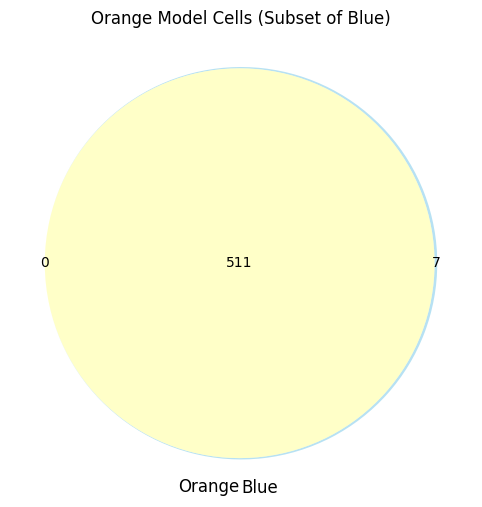

In [119]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# Load both datasets
orange_df = pd.read_csv('./active_learning_output_files/Orange_model_1_excised_cells_old_LRZ.csv')
blue_df = pd.read_csv('./active_learning_output_files/Blue_model_excised_cells_old_LRZ.csv')

# Extract unique cell IDs
orange_ids = set(orange_df['Cell ID'])
blue_ids = set(blue_df['Cell ID'])

# Create the Venn diagram with customized colors
plt.figure(figsize=(8, 6))
venn = venn2(
    [orange_ids, blue_ids],
    set_labels=("Orange", "Blue"),
    set_colors=("yellow", "skyblue"),
    alpha=0.6
)

# Optional: highlight if Orange is subset of Blue
if orange_ids.issubset(blue_ids):
    plt.title("Orange Model Cells (Subset of Blue)")
else:
    plt.title("Cell Overlap Between Orange and Blue Models")

plt.show()

In [120]:
import numpy as np

# Setup
total_cells = 106433
screening_cells = 99270
bin_labeled_indices = np.zeros(total_cells)
bin_labeled_indices[:1105] = 1  # 1105 cells with bin info

# Run permutations
n_iterations = 10000
random_excised_counts = []

for _ in range(n_iterations):
    sample = np.random.choice(total_cells, screening_cells, replace=False)
    count = bin_labeled_indices[sample].sum()
    random_excised_counts.append(count)

# Compare AL performance
al_count = 518
p_value = np.mean(np.array(random_excised_counts) >= al_count)
print(f"Empirical p-value: {p_value}")


Empirical p-value: 1.0


In [121]:
from scipy.stats import chi2_contingency

# Create a 2x2 table
# Rows: AL vs Random
# Columns: With Bin Info, Without Bin Info

al_with_bin = 518
al_without_bin = total_screening_cells - 518

expected_bin_rate = total_with_bin_info / total_cells
expected_bin_count = total_screening_cells * expected_bin_rate

random_with_bin = expected_bin_count
random_without_bin = total_screening_cells - expected_bin_count

table = [
    [al_with_bin, al_without_bin],
    [random_with_bin, random_without_bin]
]

chi2, p, _, _ = chi2_contingency(table)
print(f"Chi-squared p-value: {p}")

Chi-squared p-value: 6.378224719705125e-42
